In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import plotly.graph_objects as go

# UN CLIMATE EQUITY & ACCOUNTABILITY DESIGN FRAMEWORK
UN_COLORS = {
    # Foundation
    'slate_grey': '#000000',
    'un_blue': '#009EDB',
    
    # Emissions Gradient (Income Groups)
    'high_income': '#C0392B',      # Rust/Danger
    'upper_middle': '#F1C40F',     # Mustard
    'lower_middle': '#1ABC9C',     # Teal
    'low_income': '#16A085',       # Soft Teal
    
    # Action Binary (Colorblind-safe)
    'negative': '#D35400',         # Vermilion (increases/bad)
    'positive': '#1ABC9C',         # Emerald (decreases/good)
    
    # Trade/Production-Consumption
    'importer': '#2C3E50',         # Dark Blue
    'exporter': '#C0392B',         # Rust Orange
}

# Income Group Color Palette (ordered)
INCOME_COLORS = [
    UN_COLORS['high_income'],
    UN_COLORS['upper_middle'],
    UN_COLORS['lower_middle'],
    UN_COLORS['low_income']
]

# 1. LOAD DATA
df = pd.read_csv('cleaned_co2_data_enriched.csv')

# Set UN Design Framework Styling
sns.set_theme(style="white")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = UN_COLORS['slate_grey']
plt.rcParams['axes.labelcolor'] = UN_COLORS['slate_grey']
plt.rcParams['text.color'] = UN_COLORS['slate_grey']
plt.rcParams['xtick.color'] = UN_COLORS['slate_grey']
plt.rcParams['ytick.color'] = UN_COLORS['slate_grey']
plt.rcParams['grid.color'] = '#ECEFF1'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 11

# --- DATA PREPARATION ---

# Global Data
global_df = df.groupby('Year').sum(numeric_only=True).reset_index()

# Decadal Data (Filtered for 1950s-2010s)
global_df['Decade'] = (global_df['Year'] // 10) * 10
# Include 1940s in calculation to get correct growth for 1950s
decade_df_calc = global_df[global_df['Year'] >= 1940].groupby('Decade')['CO2 Emissions'].sum().reset_index()
decade_df_calc['Growth_Rate'] = decade_df_calc['CO2 Emissions'].pct_change() * 100
# Filter for final display
decade_df = decade_df_calc[(decade_df_calc['Decade'] >= 1950) & (decade_df_calc['Decade'] < 2020)].copy()

# Top 20 Countries
countries_2023 = df[df['Year'] == 2023].copy()
top_20 = countries_2023.sort_values('CO2 Emissions', ascending=False).head(20)
top_20['Cumulative_Pct'] = top_20['CO2 Emissions'].cumsum() / countries_2023['CO2 Emissions'].sum() * 100

# Sources Data
sources_cols = ['Coal CO2 Emissions', 'Oil CO2 Emissions', 'Gas CO2 Emissions',
           'Cement CO2 Emissions', 'Flaring CO2 Emissions', 'Land Use Change CO2']
# UPDATED LINE BELOW
sources_labels = ['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Land Use Change']
global_sources = df.groupby('Year')[sources_cols].sum().reset_index()

# Temp Change Data
temp_cols = ['Temperature Change From CO2', 'Temperature Change From Methane', 'Temperature Change From Nitrous Oxide']
countries_2023['Total_Temp_Change'] = countries_2023[temp_cols].sum(axis=1)
top_temp = countries_2023.sort_values('Total_Temp_Change', ascending=False).head(10)

# Define Consistent Colors
source_colors = sns.color_palette("Spectral", len(sources_labels))
color_map = dict(zip(sources_labels, source_colors))

## What is the growth rate of global emissions by decade (1950s-2020s)?

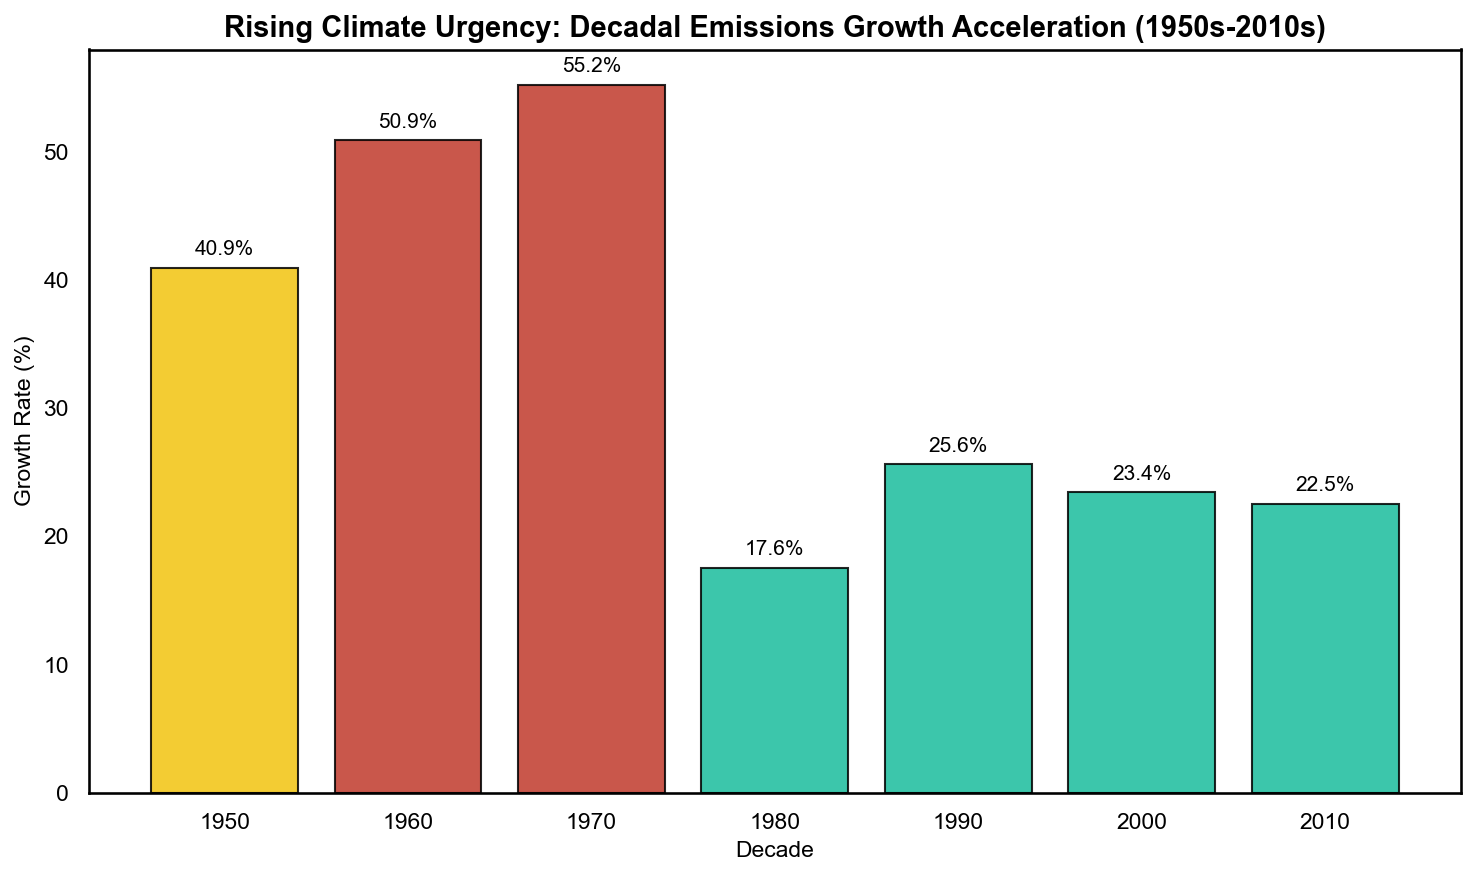

In [2]:
# Create color gradient: Teal (low) → Mustard → Rust (high)
growth_values = decade_df['Growth_Rate'].values
colors_growth = []
for val in growth_values:
    if pd.notna(val):
        if val < 30:
            colors_growth.append(UN_COLORS['lower_middle'])  # Teal for lower growth
        elif val < 50:
            colors_growth.append(UN_COLORS['upper_middle'])  # Mustard for medium
        else:
            colors_growth.append(UN_COLORS['high_income'])   # Rust for high growth
    else:
        colors_growth.append(UN_COLORS['slate_grey'])

plt.figure(figsize=(10, 6))
bars = plt.bar(decade_df['Decade'].astype(str), decade_df['Growth_Rate'], color=colors_growth, alpha=0.85, edgecolor=UN_COLORS['slate_grey'], linewidth=1)
plt.title('Rising Climate Urgency: Decadal Emissions Growth Acceleration (1950s-2010s)', fontsize=14, fontweight='bold')
plt.ylabel('Growth Rate (%)')
plt.xlabel('Decade')
plt.grid(False)
for i, v in enumerate(decade_df['Growth_Rate']):
    if pd.notna(v):
        plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10, color=UN_COLORS['slate_grey'])
plt.tight_layout()
plt.show()


## What is the cumulative CO₂ burden by income group since 1850?

In [3]:
# Filter historical data from 1850 onwards
df_historical = df[df['Year'] >= 1850].copy()

# Calculate cumulative emissions by income group
cumulative_by_income = df_historical.groupby('Income Group')['CO2 Emissions'].sum().sort_values(ascending=False)

# Convert to Gigatons
cumulative_gt = cumulative_by_income / 1000

# Calculate percentages
total_cumulative = cumulative_gt.sum()
percentages = (cumulative_gt / total_cumulative * 100)

# Create figure
fig = go.Figure()

# Map income groups to UN colors
income_color_map = {
    'High Income': UN_COLORS['high_income'],
    'Upper-Middle Income': UN_COLORS['upper_middle'],
    'Lower-Middle Income': UN_COLORS['lower_middle'],
    'Low Income': UN_COLORS['low_income']
}
colors = [income_color_map.get(group, UN_COLORS['slate_grey']) for group in cumulative_gt.index]

# Add bar chart
fig.add_trace(go.Bar(
    x=cumulative_gt.index,
    y=cumulative_gt.values,
    text=[f'{val:.1f} Gt<br>({pct:.1f}%)' for val, pct in zip(cumulative_gt.values, percentages.values)],
    textposition='outside',
    marker=dict(
        color=colors,
        line=dict(color=UN_COLORS['slate_grey'], width=1.5)
    ),
    hovertemplate='<b>%{x}</b><br>Cumulative Emissions: %{y:.1f} Gt<br>Share: %{customdata:.1f}%<extra></extra>',
    customdata=percentages.values,
    showlegend=False
))

# Update layout
fig.update_layout(
    title=dict(
        text='Cumulative CO₂ Burden by Income Group (1850-2023)<br><sub>"Who Filled Up The Carbon Budget?"</sub>',
        font=dict(size=22, color=UN_COLORS['slate_grey'], family='Arial'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Income Group',
        tickfont=dict(size=13, color=UN_COLORS['slate_grey']),
        showgrid=False
    ),
    yaxis=dict(
        title='Cumulative CO₂ Emissions (Gigatons)',
        tickfont=dict(size=12, color=UN_COLORS['slate_grey']),
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    plot_bgcolor='white',
    width=1000,
    height=600,
    margin=dict(l=80, r=60, t=120, b=80)
)

# Save and show
fig.show()

## What is the cumulative CO₂ burden by income group since 1850?

In [4]:
# Filter historical data from 1850 onwards
df_historical = df[df['Year'] >= 1850].copy()

# Get current population by country
latest_year = df['Year'].max()
df_current = df[df['Year'] == latest_year].copy()

# Calculate cumulative emissions by country (in tons)
cumulative_by_country = df_historical.groupby('Country')['CO2 Emissions'].sum()

# Get current population by country
current_population = df_current.set_index('Country')['Population']

# Calculate per capita cumulative emissions
# Emissions appear to be in million tons (Mt), so multiply by 1,000,000 to get tons
# Then divide by population to get tons per person
common_countries = cumulative_by_country.index.intersection(current_population.index)
per_capita_cumulative = (cumulative_by_country[common_countries] * 1_000_000) / current_population[common_countries]

# Remove any NaN or infinite values and filter countries with reasonable population
per_capita_cumulative = per_capita_cumulative[
    (per_capita_cumulative.notna()) & 
    (per_capita_cumulative != float('inf')) &
    (current_population[common_countries] > 100000)  # Filter out very small countries
]

# Get top 20 countries
top_20_percapita = per_capita_cumulative.nlargest(20).sort_values(ascending=True)

# Create horizontal bar chart
fig = go.Figure()

# Create color gradient: Rust (top emitters) → Mustard → Teal (lower emitters)
colors = []
for i in range(len(top_20_percapita)):
    if i >= 15:  # Top 5 (highest)
        colors.append(UN_COLORS['high_income'])  # Rust
    elif i >= 10:  # Next 5
        colors.append(UN_COLORS['upper_middle'])  # Mustard
    elif i >= 5:  # Next 5
        colors.append('#95A5A6')  # Light grey
    else:  # Bottom 5
        colors.append(UN_COLORS['lower_middle'])  # Teal

fig.add_trace(go.Bar(
    y=top_20_percapita.index,
    x=top_20_percapita.values,
    orientation='h',
    text=[f'{val:,.0f}' for val in top_20_percapita.values],
    textposition='outside',
    marker=dict(
        color=colors,
        line=dict(color=UN_COLORS['slate_grey'], width=1)
    ),
    hovertemplate='<b>%{y}</b><br>Per Capita Cumulative: %{x:,.0f} tons/person<extra></extra>',
    showlegend=False
))

# Update layout
fig.update_layout(
    title=dict(
        text='Historical Carbon Debt Per Person: Top 20 Countries<br><sub>Per Capita Cumulative CO₂ Emissions (1850-2023)</sub>',
        font=dict(size=18, color=UN_COLORS['slate_grey'], family='Arial'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Cumulative CO₂ Emissions (tons per person)',
        tickfont=dict(size=11, color=UN_COLORS['slate_grey']),
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    yaxis=dict(
        tickfont=dict(size=11, color=UN_COLORS['slate_grey']),
        showgrid=False
    ),
    plot_bgcolor='white',
    height=700,
    width=1000,
    margin=dict(l=150, r=80, t=120, b=80)
)

# Save and show
fig.show()

## What is the global temperature contribution of different income groups?

In [5]:
# Calculate total temperature change contribution by income group
temp_by_income = df.groupby('Income Group')['Temperature Change From CO2'].sum()
total_temp = temp_by_income.sum()
temp_percentage = (temp_by_income / total_temp * 100)

temp_by_income_sorted = temp_by_income.sort_values(ascending=False)
temp_percentage_sorted = temp_percentage[temp_by_income_sorted.index]

print("\nTotal Temperature Change from CO2 by Income Group:")
for group in temp_by_income_sorted.index:
    temp = temp_by_income_sorted[group]
    pct = temp_percentage_sorted[group]
    print(f"  {group}: {temp:.4f}°C ({pct:.1f}%)")

print(f"\nTotal: {total_temp:.4f}°C")

# Create visualization
fig = go.Figure()

# Map income groups to UN colors
income_color_map = {
    'High Income': UN_COLORS['high_income'],
    'Upper-Middle Income': UN_COLORS['upper_middle'],
    'Lower-Middle Income': UN_COLORS['lower_middle'],
    'Low Income': UN_COLORS['low_income']
}
colors = [income_color_map.get(group, UN_COLORS['slate_grey']) for group in temp_by_income_sorted.index]

fig.add_trace(go.Bar(
    x=list(temp_by_income_sorted.index),
    y=list(temp_by_income_sorted.values),
    marker=dict(color=colors, line=dict(color='white', width=2)),
    text=[f'{v:.4f}°C<br>({temp_percentage_sorted[idx]:.1f}%)' 
          for idx, v in zip(temp_by_income_sorted.index, temp_by_income_sorted.values)],
    textposition='outside',
    textfont=dict(size=12, color=UN_COLORS['slate_grey'], family='Arial'),
))

fig.update_layout(
    title=dict(
        text='Who Warmed the Planet? Temperature Contribution by Income Group<br><sub>Historical Warming Caused by Different Income Groups</sub>',
        font=dict(size=18, color=UN_COLORS['slate_grey'], family='Arial'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(title='Income Group', tickfont=dict(size=12, color=UN_COLORS['slate_grey']), showgrid=False),
    yaxis=dict(title='Temperature Change from CO₂ (°C)', tickfont=dict(size=11, color=UN_COLORS['slate_grey']),
               showgrid=False, gridcolor='lightgray', gridwidth=0.5),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False,
    height=600,
    width=1000,
    margin=dict(t=120, b=80, l=80, r=50)
)

high_income_temp = temp_by_income_sorted['High Income']
high_income_pct = temp_percentage_sorted['High Income']

print("\n✓ Q9 visualization saved: q9_temperature_contribution_by_income.png")
fig.show()



Total Temperature Change from CO2 by Income Group:
  High Income: 28.4783°C (53.5%)
  Upper-Middle Income: 18.2031°C (34.2%)
  Lower-Middle Income: 5.3137°C (10.0%)
  Low Income: 1.1964°C (2.2%)

Total: 53.1915°C

✓ Q9 visualization saved: q9_temperature_contribution_by_income.png


## Which 20 countries account for 80% of global emissions

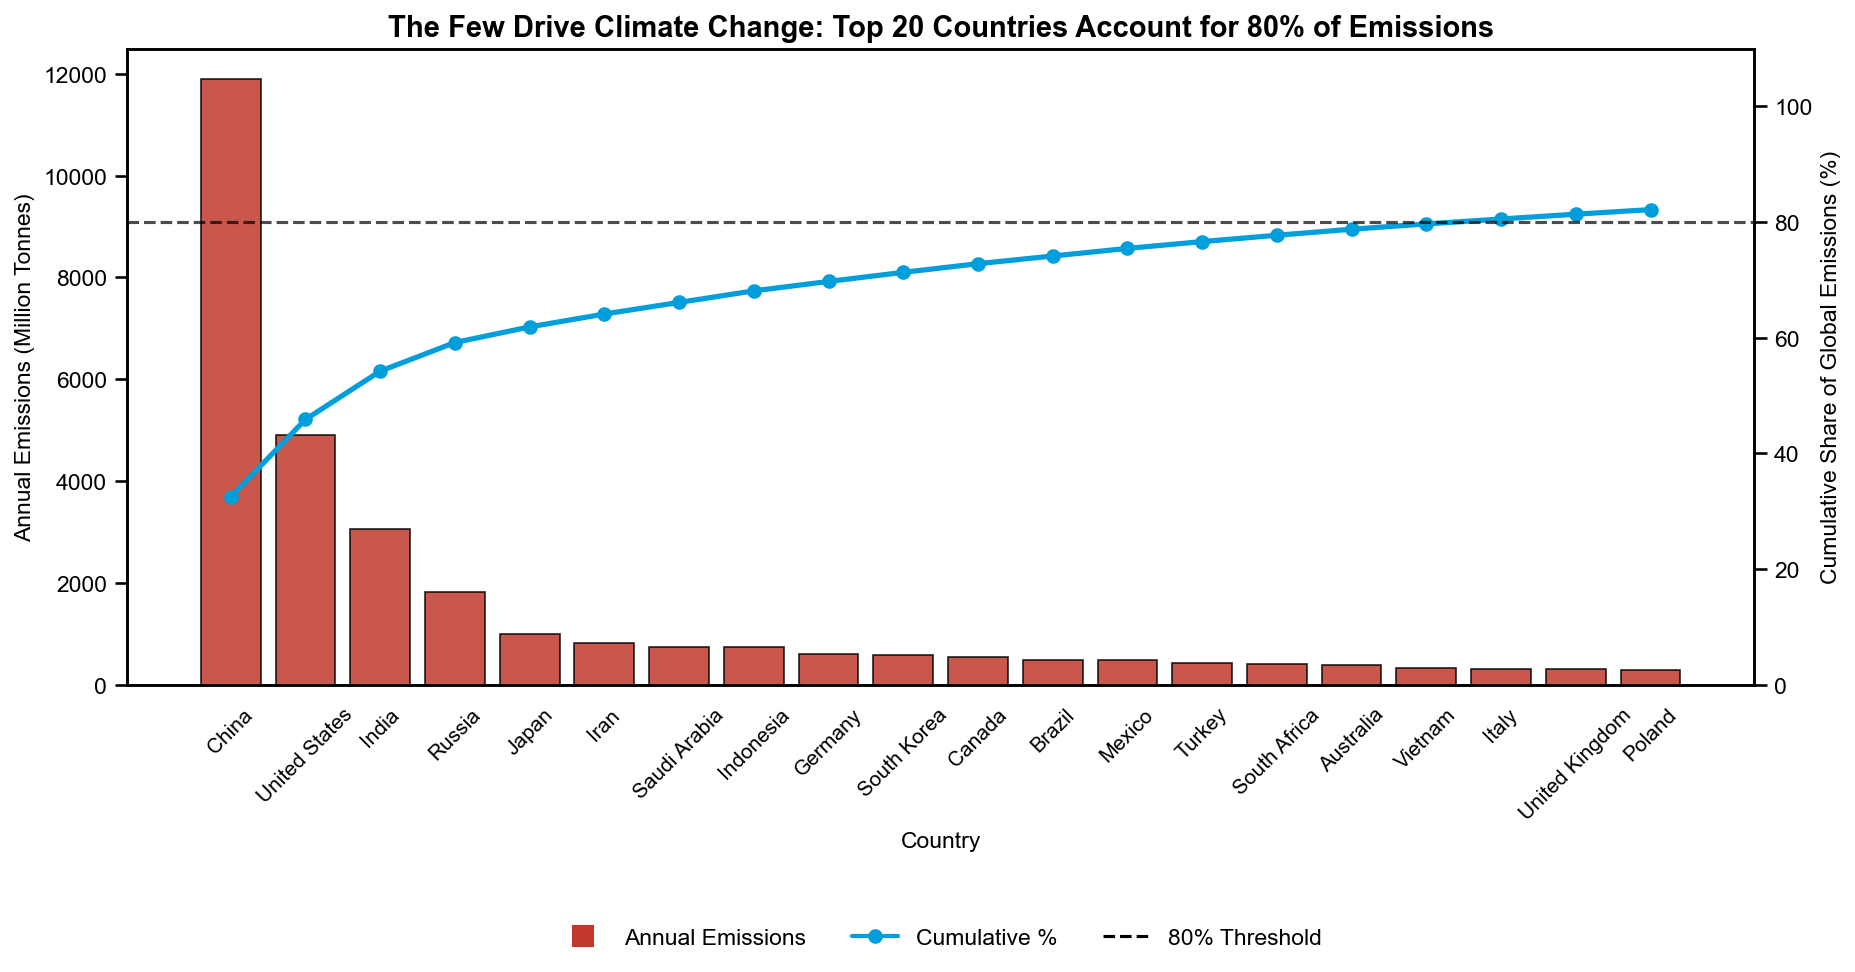

In [6]:
fig, ax1 = plt.subplots(figsize=(14, 8))
# Primary Axis (Bar Chart) - Use Rust for high emissions
bars = ax1.bar(top_20['Country'], top_20['CO2 Emissions'], color=UN_COLORS['high_income'], 
               alpha=0.85, edgecolor=UN_COLORS['slate_grey'], linewidth=0.8)
ax1.set_ylabel('Annual Emissions (Million Tonnes)', color=UN_COLORS['slate_grey'])
ax1.set_xlabel('Country', color=UN_COLORS['slate_grey'])
ax1.tick_params(axis='x', rotation=45, labelsize=10, colors=UN_COLORS['slate_grey'])
ax1.tick_params(axis='y', colors=UN_COLORS['slate_grey'])
ax1.grid(False)
# Secondary Axis (Line Chart) - Use UN Blue
ax2 = ax1.twinx()
ax2.plot(range(len(top_20)), top_20['Cumulative_Pct'].values, color=UN_COLORS['un_blue'], 
         marker='o', linewidth=2.5, markersize=6)
ax2.set_ylabel('Cumulative Share of Global Emissions (%)', color=UN_COLORS['slate_grey'])
ax2.set_ylim(0, 110)
ax2.tick_params(axis='y', colors=UN_COLORS['slate_grey'])
ax2.grid(False)
# Threshold Line
ax2.axhline(80, color=UN_COLORS['slate_grey'], linestyle='--', linewidth=1.5, alpha=0.7)
# Custom Unified Legend
handle_bar = mlines.Line2D([], [], color=UN_COLORS['high_income'], marker='s', linestyle='None', 
                           markersize=10, label='Annual Emissions')
handle_line = mlines.Line2D([], [], color=UN_COLORS['un_blue'], marker='o', linewidth=2, label='Cumulative %')
handle_threshold = mlines.Line2D([], [], color=UN_COLORS['slate_grey'], linestyle='--', linewidth=1.5, label='80% Threshold')
ax1.legend(handles=[handle_bar, handle_line, handle_threshold],
           loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=3, frameon=False)
plt.title('The Few Drive Climate Change: Top 20 Countries Account for 80% of Emissions', 
          fontsize=14, fontweight='bold', color=UN_COLORS['slate_grey'])
plt.subplots_adjust(bottom=0.35)
plt.show()

## Which countries contribute most to temperature change from CO2 vs methane vs nitrous oxide?

<Figure size 1800x900 with 0 Axes>

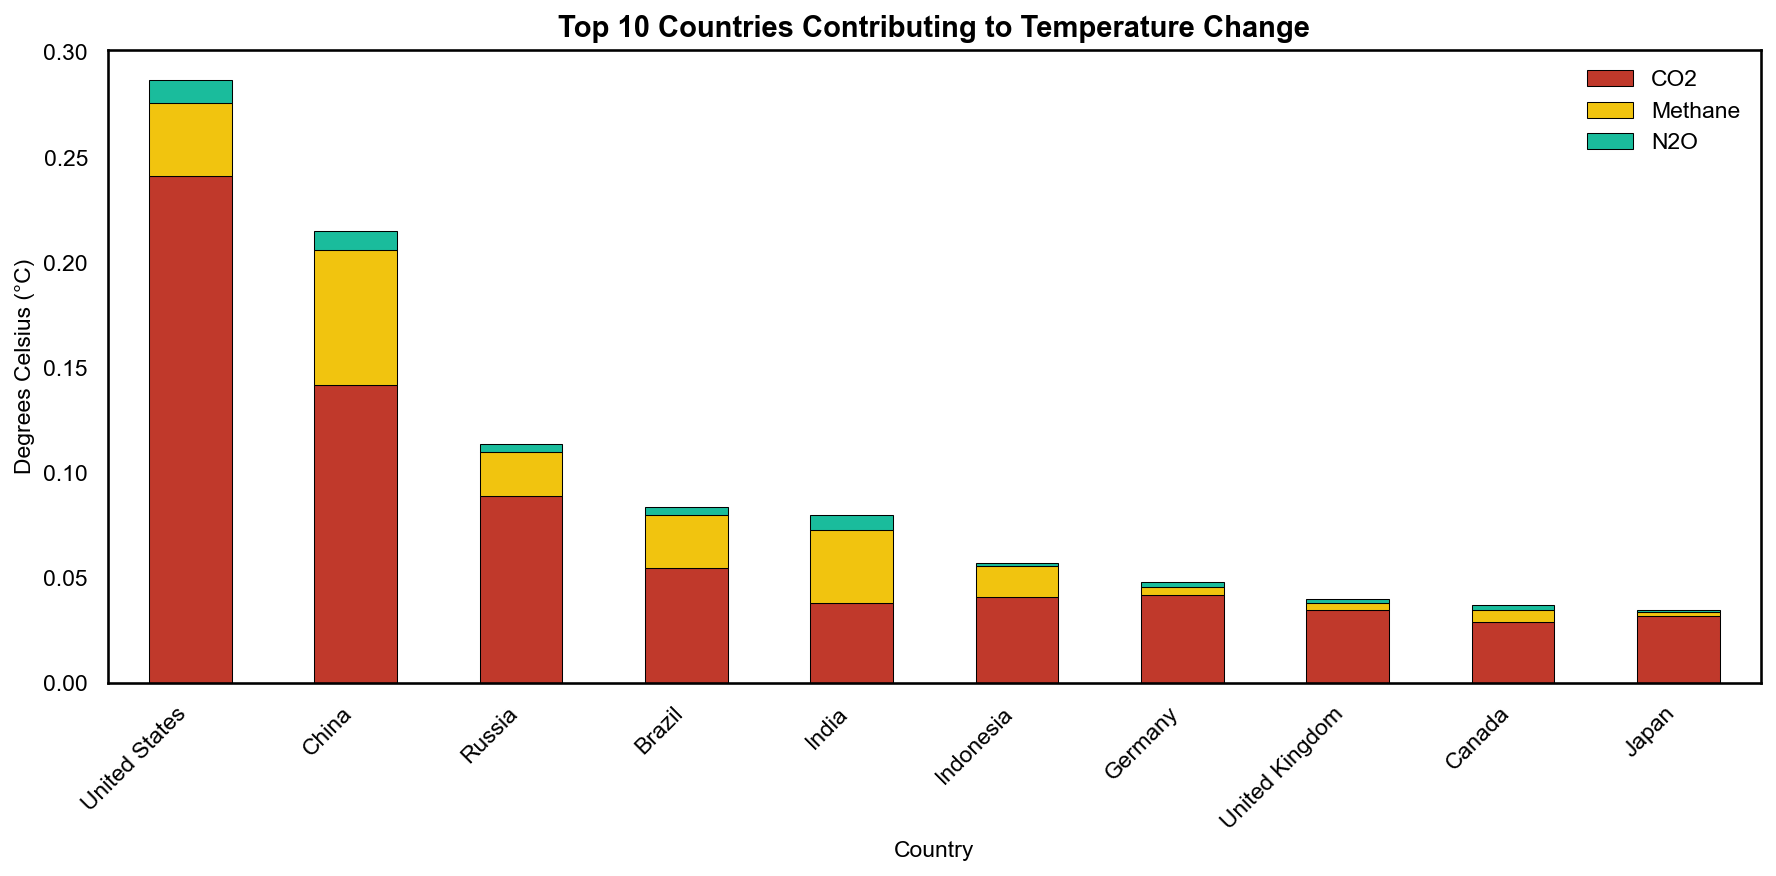

In [7]:
plt.figure(figsize=(12, 6))
# UN colors for different gases: CO2 (Rust), Methane (Mustard), N2O (Teal)
gas_colors = [UN_COLORS['high_income'], UN_COLORS['upper_middle'], UN_COLORS['lower_middle']]
top_temp.set_index('Country')[temp_cols].plot(kind='bar', stacked=True,
                                             color=gas_colors,
                                             figsize=(12, 6), 
                                             edgecolor=UN_COLORS['slate_grey'], linewidth=0.5)
plt.title('Top 10 Countries Contributing to Temperature Change', fontsize=14, fontweight='bold')
plt.ylabel('Degrees Celsius (°C)')
plt.xlabel('Country')
plt.xticks(rotation=45, ha='right')
plt.legend(['CO2', 'Methane', 'N2O'], frameon=False)
plt.grid(False)
plt.tight_layout()
plt.show()

## What is the current trajectory of global CO2 emissions?

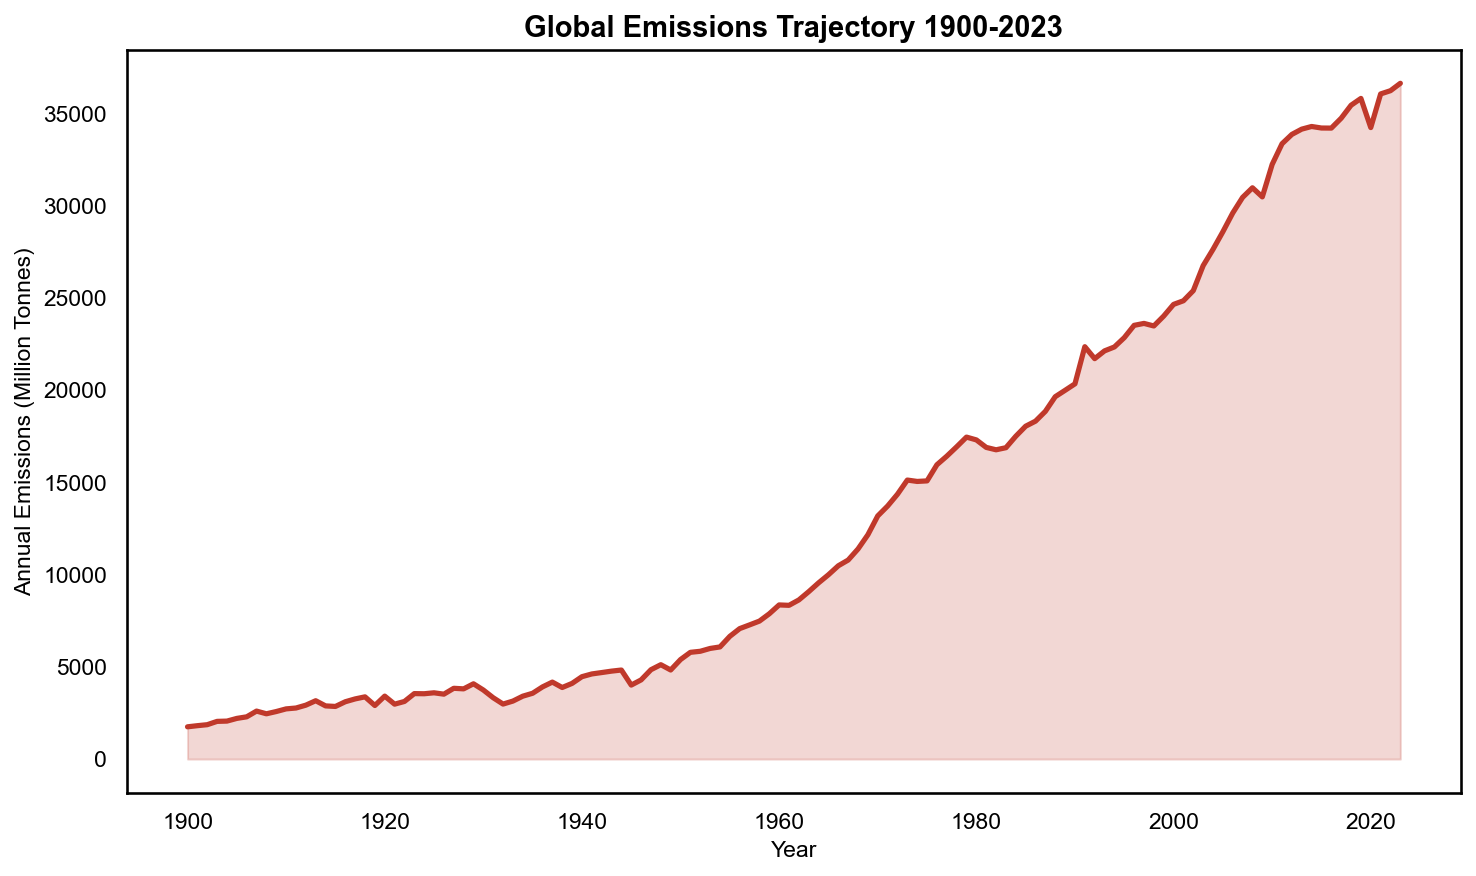

In [8]:
plt.figure(figsize=(10, 6))
# Use Rust to emphasize danger of rising emissions
plt.plot(global_df[global_df['Year']>=1900]['Year'], 
         global_df[global_df['Year']>=1900]['CO2 Emissions'], 
         linewidth=2.5, color=UN_COLORS['high_income'])
plt.title('Global Emissions Trajectory 1900-2023', fontsize=14, fontweight='bold')
plt.ylabel('Annual Emissions (Million Tonnes)')
plt.xlabel('Year')
plt.fill_between(global_df[global_df['Year']>=1900]['Year'], 
                 global_df[global_df['Year']>=1900]['CO2 Emissions'], 
                 color=UN_COLORS['high_income'], alpha=0.2)
plt.grid(False)
plt.tight_layout()
plt.show()


## Which emission sources are growing fastest globally?

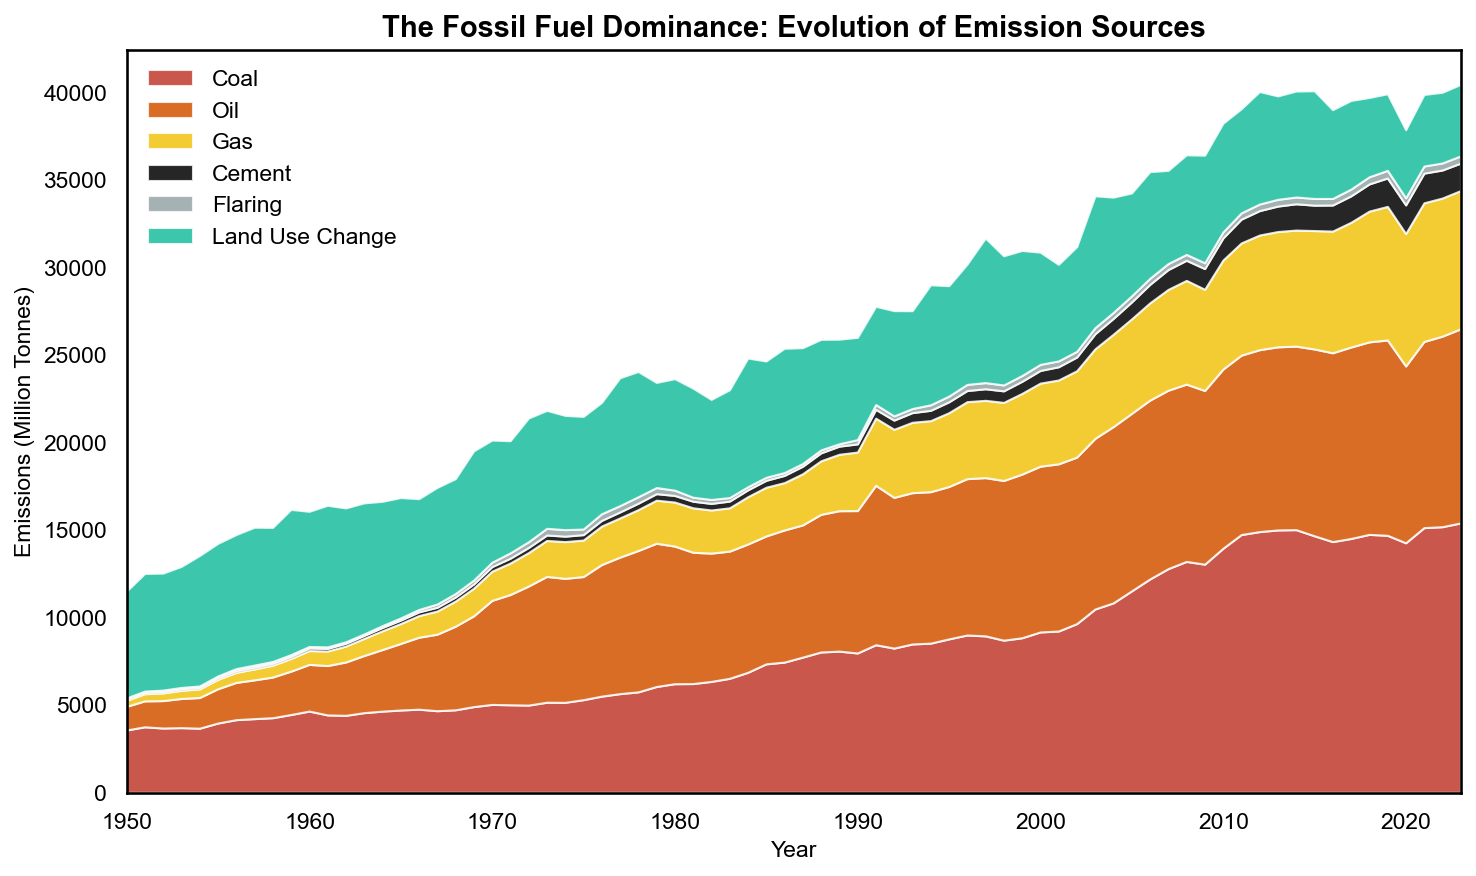

In [9]:
# Create UN color map for emission sources
source_color_map_un = {
    'Coal': UN_COLORS['high_income'],      # Rust - historical villain
    'Oil': UN_COLORS['negative'],          # Dark Orange
    'Gas': UN_COLORS['upper_middle'],      # Mustard
    'Cement': UN_COLORS['slate_grey'],     # Slate Grey
    'Flaring': '#95A5A6',                  # Light Grey
    'Land Use Change': UN_COLORS['lower_middle']  # Teal
}

plt.figure(figsize=(10, 6))
plt.stackplot(global_sources['Year'],
              [global_sources[col] for col in sources_cols],
              labels=sources_labels, alpha=0.85,
              colors=[source_color_map_un[l] for l in sources_labels])
plt.title('The Fossil Fuel Dominance: Evolution of Emission Sources', fontsize=14, fontweight='bold')
plt.ylabel('Emissions (Million Tonnes)')
plt.xlabel('Year')
plt.xlim(1950, 2023)
plt.legend(loc='upper left', frameon=False)
plt.grid(False)
plt.tight_layout()
plt.show()

## In 2023, what percentage of global emissions comes from each source?

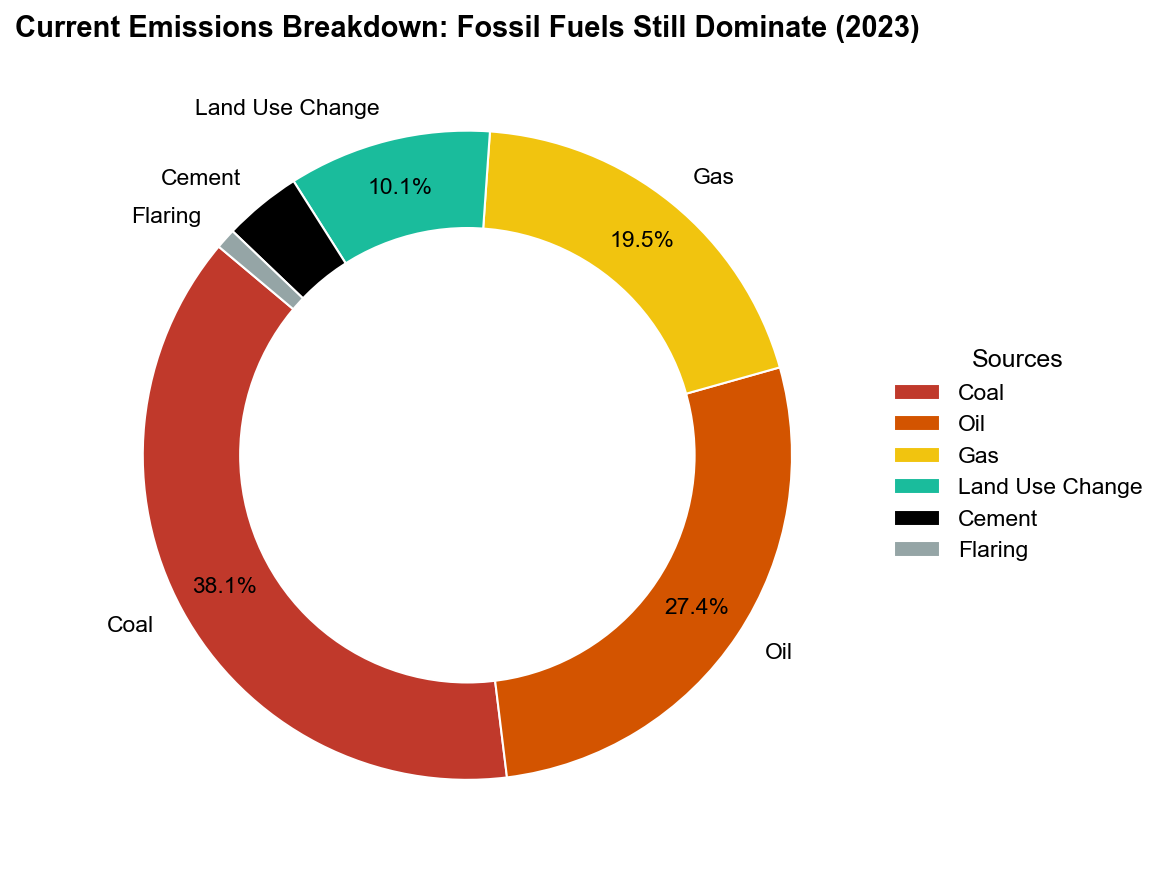

In [10]:
plt.figure(figsize=(10, 6))
latest_sources = global_sources[global_sources['Year'] == 2023][sources_cols].T
latest_sources.columns = ['Value']
latest_sources.index = sources_labels # Applies "Land Use Change" label
latest_sources = latest_sources.sort_values('Value', ascending=False)
pie_labels = latest_sources.index
# Use same UN color palette as Cell 16
pie_colors = [source_color_map_un[l] for l in pie_labels]
wedges, texts, autotexts = plt.pie(latest_sources['Value'], labels=pie_labels,
                                   autopct='%1.1f%%', startangle=140,
                                   colors=pie_colors, pctdistance=0.85,
                                   textprops={'color': UN_COLORS['slate_grey'], "fontsize": 11})


plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))

values = [38.1, 27.4, 19.5, 10.1, 3.9, 1.0]

for i, autotext in enumerate(autotexts):
    # Hide tiny labels (< 2%)
    if values[i] < 2.0:
        autotext.set_visible(False)

plt.title('Current Emissions Breakdown: Fossil Fuels Still Dominate (2023)', fontsize=14, fontweight='bold')
plt.legend(wedges, pie_labels, title="Sources", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), frameon=False)
plt.tight_layout()
plt.show()

## Which countries are net exporters vs importers of carbon through trade?

Using Trade CO2 year: 2022


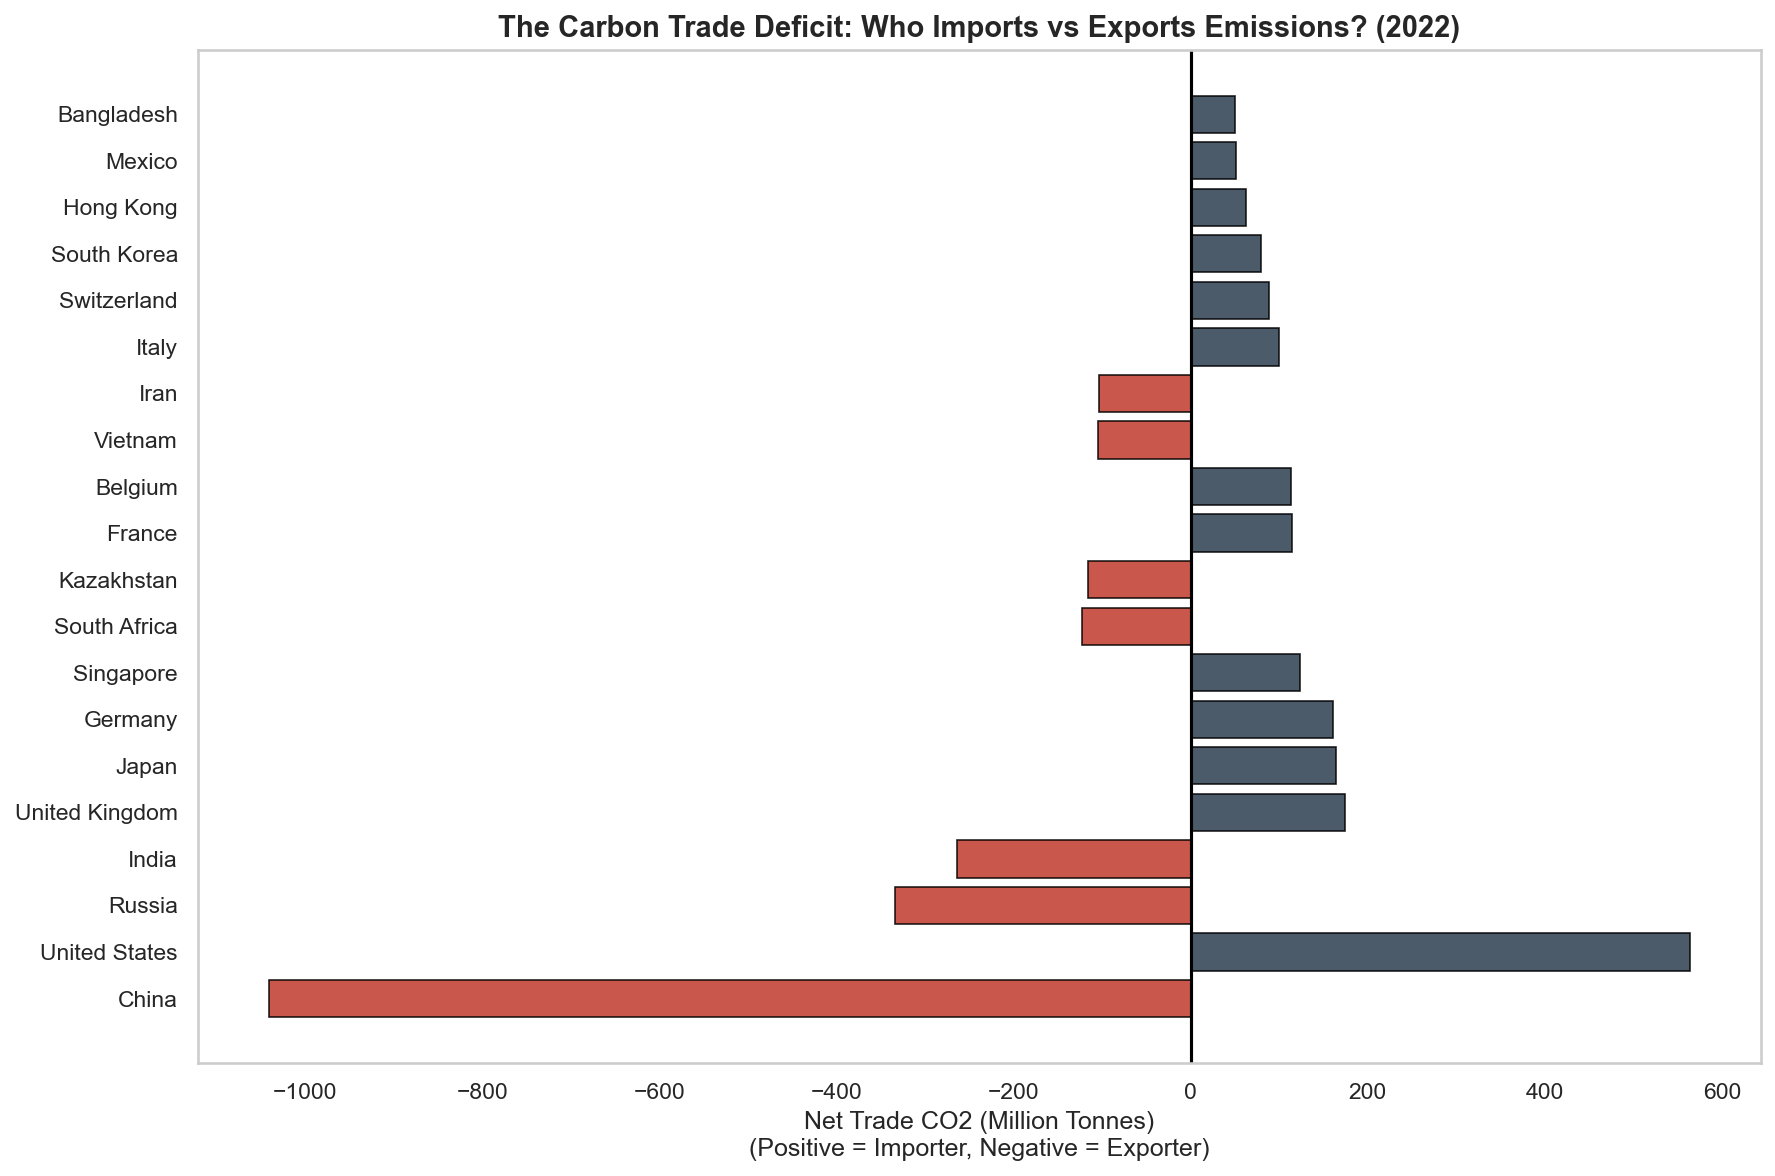

In [11]:
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'


# --- CHART 4: Global Trade Balance (WORKING VERSION) ---

# 1. Automatically find latest year with non-zero Trade CO2
trade_years = df[df["Trade CO2"] != 0]["Year"]
if not trade_years.empty:
    target_year_trade = trade_years.max()
else:
    target_year_trade = df["Year"].max()   # fallback

print("Using Trade CO2 year:", target_year_trade)

# 2. Filter top 20 countries by absolute trade emissions
trade_df = df[df["Year"] == target_year_trade][["Country", "Trade CO2"]].copy()
trade_df = trade_df.dropna(subset=["Trade CO2"])
trade_df = trade_df.sort_values("Trade CO2", key=abs, ascending=False).head(20)

# 3. Color: Dark Blue = importer (positive), Rust = exporter (negative) - colorblind safe
colors = [UN_COLORS['importer'] if x > 0 else UN_COLORS['exporter'] for x in trade_df["Trade CO2"]]

# 4. Plot as horizontal bar chart (best for ranking)
plt.figure(figsize=(12, 8))
plt.barh(trade_df["Country"], trade_df["Trade CO2"], color=colors, alpha=0.85, 
         edgecolor=UN_COLORS['slate_grey'], linewidth=0.8)

plt.title(f"The Carbon Trade Deficit: Who Imports vs Exports Emissions? ({target_year_trade})", 
          fontsize=14, fontweight='bold')
plt.xlabel("Net Trade CO2 (Million Tonnes)\n(Positive = Importer, Negative = Exporter)")
plt.axvline(0, color=UN_COLORS['slate_grey'], linewidth=1.5)
plt.grid(False)

plt.tight_layout()
plt.show()


## Which countries have the largest gap between production and consumption?

Plotting Emission Gap for Year: 2022


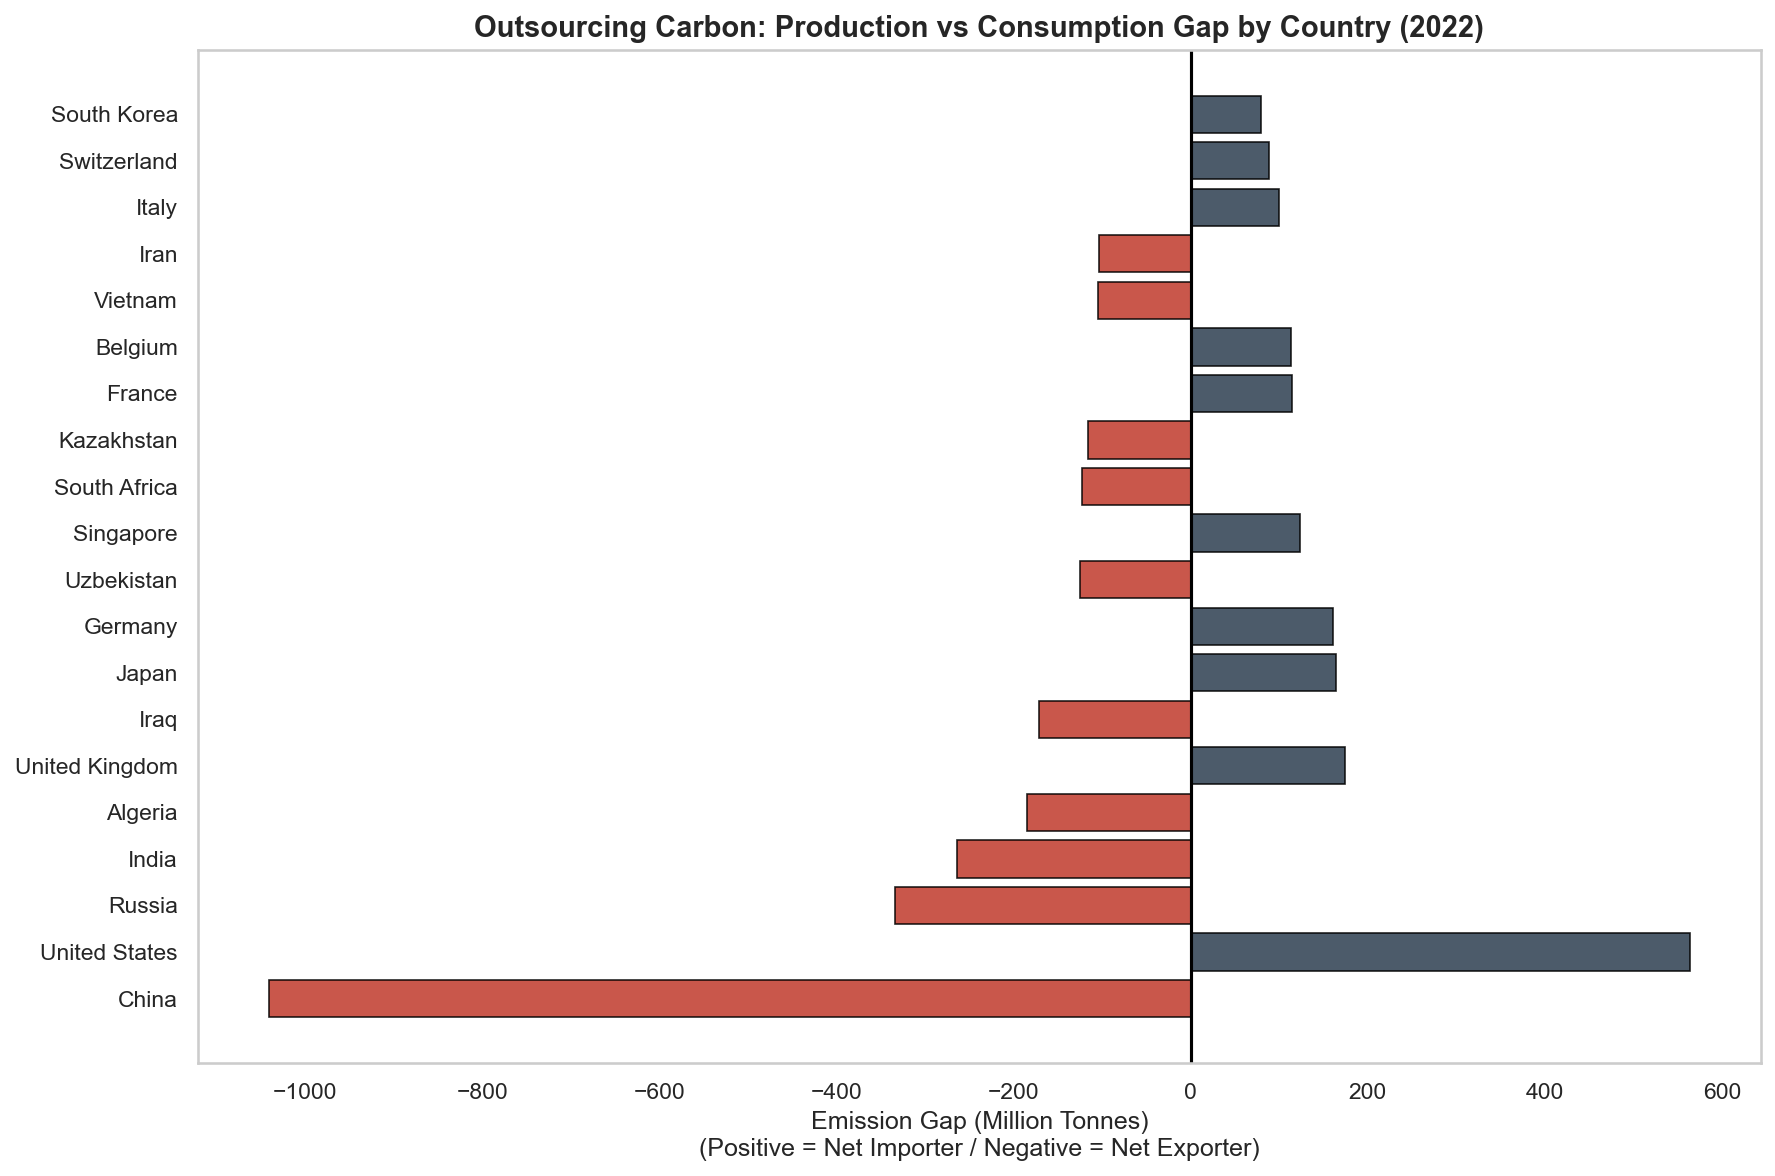

In [12]:
valid_years = df[
    (df['Consumption CO2'].notna()) & (df['Consumption CO2'] != 0) &
    (df['CO2 Emissions'].notna()) & (df['CO2 Emissions'] != 0)
]['Year']
latest_gap_year = valid_years.max() if not valid_years.empty else 2021

print(f"Plotting Emission Gap for Year: {latest_gap_year}")

# 2. Prepare Data for that year
gap_df = df[df['Year'] == latest_gap_year].copy()

# Calculate the Gap: Positive = Net Importer, Negative = Net Exporter
gap_df['Emission Gap'] = gap_df['Consumption CO2'] - gap_df['CO2 Emissions']

# Sort by the MAGNITUDE of the gap (absolute value) to find the biggest disparities
top_gap_countries = gap_df.sort_values('Emission Gap', key=abs, ascending=False).head(20)

# 3. Plot
plt.figure(figsize=(12, 8))

# Color logic: Dark Blue for Net Importers, Rust for Net Exporters - colorblind safe
colors = [UN_COLORS['importer'] if x > 0 else UN_COLORS['exporter'] for x in top_gap_countries['Emission Gap']]

plt.barh(top_gap_countries['Country'], top_gap_countries['Emission Gap'], color=colors, alpha=0.85,
         edgecolor=UN_COLORS['slate_grey'], linewidth=0.8)

plt.title(f'Outsourcing Carbon: Production vs Consumption Gap by Country ({latest_gap_year})', 
          fontsize=14, fontweight='bold')
plt.xlabel('Emission Gap (Million Tonnes)\n(Positive = Net Importer / Negative = Net Exporter)')
plt.axvline(0, color=UN_COLORS['slate_grey'], linewidth=1.5)
plt.grid(False)
plt.tight_layout()
plt.show()

## How have emissions shifted from Global North to Global South over time?

In [13]:
global_north_regions = [
    'Northern America',
    'Western Europe',
    'Eastern Europe',
    'Northern Europe',
    'Southern Europe',
    'Australia and New Zealand'
]

# Filter data from 1900 onwards to show the full historical shift
df_recent = df[df['Year'] >= 1900].copy()

# Create Global North/South classification
def classify_region(row):
    if row['UN Region'] in global_north_regions:
        return 'Global North'
    elif row['Country'] == 'Japan':
        return 'Global North'
    else:
        return 'Global South'

df_recent['Global Region'] = df_recent.apply(classify_region, axis=1)

# Group by decade for smoother visualization
df_recent['Decade'] = (df_recent['Year'] // 10) * 10

# Calculate emissions by Global North/South and decade
emissions_by_decade = df_recent.groupby(['Decade', 'Global Region'])['CO2 Emissions'].sum().unstack(fill_value=0)


# Calculate percentages
total_by_decade = emissions_by_decade.sum(axis=1)
emissions_pct = emissions_by_decade.div(total_by_decade, axis=0) * 100

# Create stacked area chart
fig = go.Figure()

# Add Global North first (bottom layer) - Use Rust color
fig.add_trace(go.Scatter(
    x=emissions_pct.index,
    y=emissions_pct['Global North'],
    name='Global North',
    mode='lines',
    line=dict(width=0.5, color=UN_COLORS['high_income']),
    fillcolor=UN_COLORS['high_income'],
    fill='tozeroy',
    stackgroup='one',
    hovertemplate='<b>Global North</b><br>Decade: %{x}s<br>Share: %{y:.1f}%<extra></extra>',
    opacity=0.7
))

# Add Global South (stacked on top) - Use Teal color
fig.add_trace(go.Scatter(
    x=emissions_pct.index,
    y=emissions_pct['Global South'],
    name='Global South',
    mode='lines',
    line=dict(width=0.5, color=UN_COLORS['lower_middle']),
    fillcolor=UN_COLORS['lower_middle'],
    fill='tonexty',
    stackgroup='one',
    hovertemplate='<b>Global South</b><br>Decade: %{x}s<br>Share: %{y:.1f}%<extra></extra>',
    opacity=0.7
))


# Update layout
fig.update_layout(
    title=dict(
        text='Manufacturing Migration: Emissions Shift from North to South<br><sub>How Industrialization Relocated (1900-2023)</sub>',
        font=dict(size=20, color=UN_COLORS['slate_grey'], family='Arial'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Decade',
        tickfont=dict(size=12, color=UN_COLORS['slate_grey']),
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    yaxis=dict(
        title='Share of Global Emissions (%)',
        tickfont=dict(size=12, color=UN_COLORS['slate_grey']),
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=0.5,
        range=[0, 100]
    ),
    plot_bgcolor='white',
    height=600,
    width=1100,
    margin=dict(l=80, r=60, t=120, b=80),
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='#cccccc',
        borderwidth=1
    ),
    hovermode='x unified'
)

# Save and show
fig.show()

## How can we quantify historical emissions debt and climate reparations?

In [14]:
latest_year = df['Year'].max()
df_latest = df[df['Year'] == latest_year].copy()


# Define the desired order for plotting and display (High to Low Income)
ordered_groups = ['High Income', 'Upper-Middle Income', 'Lower-Middle Income', 'Low Income']

# Calculate cumulative emissions by income group
cumulative_by_income = df.groupby('Income Group')['CO2 Emissions'].sum()
total_cumulative = cumulative_by_income.sum()
cumulative_percentage = (cumulative_by_income / total_cumulative * 100)

# Get population share
population_by_income = df_latest.groupby('Income Group')['Population'].sum()
total_population = population_by_income.sum()
population_percentage = (population_by_income / total_population * 100)

# Calculate "fair share" vs actual emissions
fair_share = (population_percentage / 100) * total_cumulative
emissions_debt = cumulative_by_income - fair_share

# Reindex the series to enforce the desired order for plotting
cumulative_by_income_ordered = cumulative_by_income.reindex(ordered_groups)
fair_share_ordered = fair_share.reindex(ordered_groups)
all_groups_ordered = list(cumulative_by_income_ordered.index)


# Create visualization
fig = go.Figure()

# Actual emissions - Use Rust color
fig.add_trace(go.Bar(
    name='Actual Historical Emissions',
    x=all_groups_ordered,
    y=cumulative_by_income_ordered.values,
    marker=dict(color=UN_COLORS['high_income'], opacity=0.85, line=dict(color='white', width=2)),
    text=[f'{v:,.0f}' for v in cumulative_by_income_ordered.values],
    textposition='outside',
    textfont=dict(size=11, color=UN_COLORS['slate_grey']),
))

# Fair share - Use Teal color
fig.add_trace(go.Bar(
    name='Fair Share (based on population)',
    x=all_groups_ordered,
    y=fair_share_ordered.values,
    marker=dict(color=UN_COLORS['lower_middle'], opacity=0.85, line=dict(color='white', width=2)),
    text=[f'{v:,.0f}' for v in fair_share_ordered.values],
    textposition='inside',
    textfont=dict(size=11, color='white'),
    textangle=0,
))

fig.update_layout(
    title=dict(
        text='Historical Emissions Debt: Actual vs Fair Share<br><sub>Climate Reparations Quantified by Income Group</sub>',
        font=dict(size=18, color=UN_COLORS['slate_grey'], family='Arial'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Income Group',
        tickfont=dict(size=12, color=UN_COLORS['slate_grey']),
        showgrid=False,
        # *** FIX for label order: set categoryorder and categoryarray ***
        categoryorder='array',
        categoryarray=ordered_groups
    ),
    yaxis=dict(title='Cumulative CO₂ Emissions (Million Tons)', tickfont=dict(size=11, color=UN_COLORS['slate_grey']),
               showgrid=True, gridcolor='lightgray', gridwidth=0.5),
    barmode='group',
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=True,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5, font=dict(size=12)),
    height=600,
    width=1000,
    margin=dict(t=130, b=80, l=80, r=50)
)
fig.show()

## Which countries have actually reduced emissions since the Paris Agreement (2015 ? )

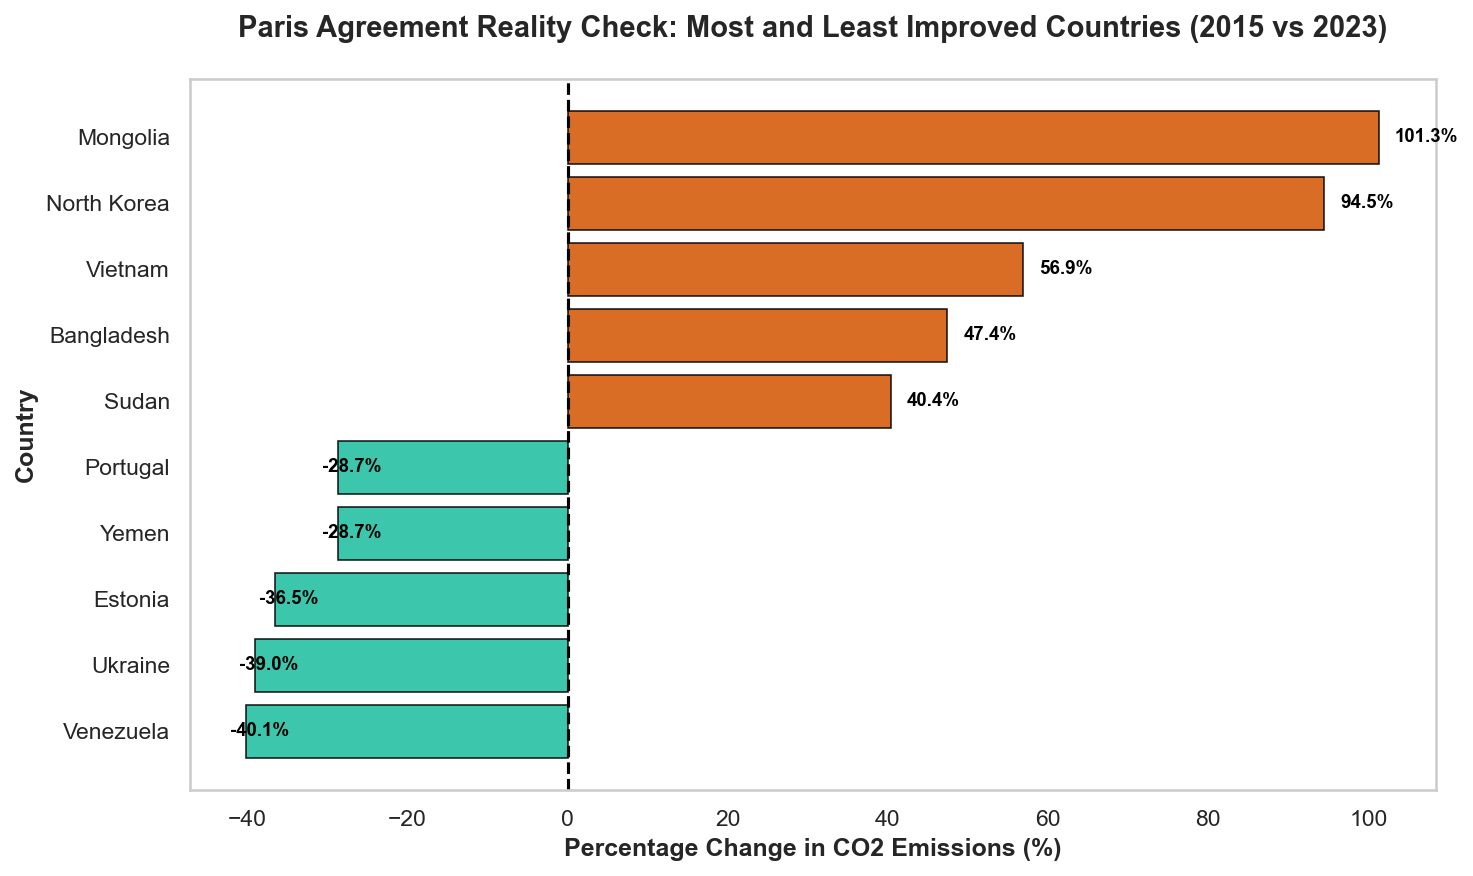

In [15]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Filter data for 2015 and latest year
latest_year = df['Year'].max()
paris_year = 2015

# Get countries with data for both years
countries_2015 = df[df['Year'] == paris_year][['Country', 'CO2 Emissions']].set_index('Country')
countries_latest = df[df['Year'] == latest_year][['Country', 'CO2 Emissions']].set_index('Country')

# Calculate percentage change
emissions_change = pd.DataFrame({
    'Country': countries_2015.index,
    'Emissions_2015': countries_2015['CO2 Emissions'].values,
    'Emissions_Latest': countries_latest.reindex(countries_2015.index)['CO2 Emissions'].values
})

# Remove countries with missing data
emissions_change = emissions_change.dropna()
emissions_change['Pct_Change'] = ((emissions_change['Emissions_Latest'] - emissions_change['Emissions_2015']) / 
                                   emissions_change['Emissions_2015']) * 100

# Filter to countries with significant emissions (> 10 Mt CO2 in 2015) for readability
emissions_change = emissions_change[emissions_change['Emissions_2015'] > 10]

# Sort by percentage change
emissions_change_sorted = emissions_change.sort_values('Pct_Change', ascending=True)

# Select top 5 most improved (biggest reductions) and top 5 least improved (biggest increases)
top5_reductions = emissions_change_sorted.head(5)
top5_increases = emissions_change_sorted.tail(5)

# Combine for focused plot: most and least improved
focus_countries = pd.concat([top5_reductions, top5_increases])
focus_countries = focus_countries.sort_values('Pct_Change')

fig, ax = plt.subplots(figsize=(10, 6))
# Teal for reductions (positive action), Vermilion for increases (negative) - colorblind safe
colors = [UN_COLORS['positive'] if x < 0 else UN_COLORS['negative'] for x in focus_countries['Pct_Change']]
bars = ax.barh(focus_countries['Country'], focus_countries['Pct_Change'], color=colors, alpha=0.85,
               edgecolor=UN_COLORS['slate_grey'], linewidth=0.8)

ax.axvline(x=0, color=UN_COLORS['slate_grey'], linestyle='--', linewidth=1.5)
ax.set_xlabel('Percentage Change in CO2 Emissions (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Country', fontsize=12, fontweight='bold')
ax.set_title(f"Paris Agreement Reality Check: Most and Least Improved Countries (2015 vs {latest_year})", 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(False)

# Add value labels
for i, (idx, row) in enumerate(focus_countries.iterrows()):
    value = row['Pct_Change']
    ax.text(value + (2 if value > 0 else -2), i, f'{value:.1f}%', 
            va='center', fontsize=9, fontweight='bold', color=UN_COLORS['slate_grey'])

plt.tight_layout()
plt.show()

## Which countries achieved absolute emissions reductions while growing GDP ? 

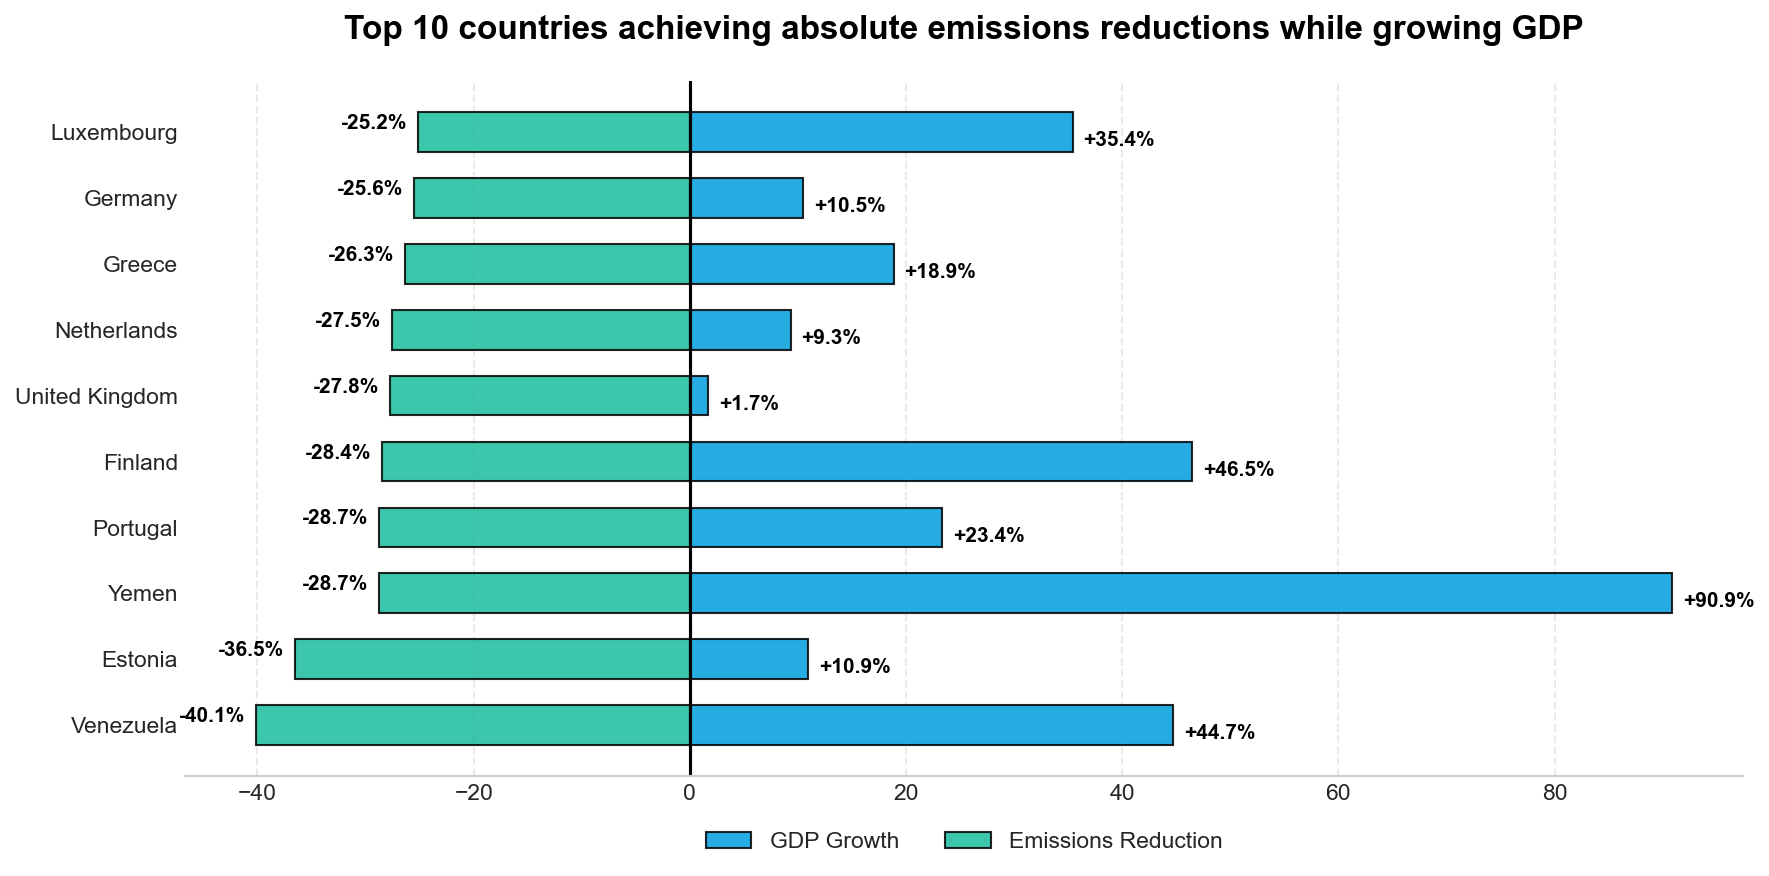

In [16]:
countries_2015_full = df[(df['Year'] == paris_year) & 
                         (df['Gross Domestic Product'].notna()) & 
                         (df['CO2 Emissions'].notna())][['Country', 'Gross Domestic Product', 'CO2 Emissions']].set_index('Country')

countries_latest_full = df[(df['Year'] == latest_year) & 
                          (df['Gross Domestic Product'].notna()) & 
                          (df['CO2 Emissions'].notna())][['Country', 'Gross Domestic Product', 'CO2 Emissions']].set_index('Country')

# Merge
data = pd.DataFrame({
    'Country': countries_2015_full.index,
    'GDP_2015': countries_2015_full['Gross Domestic Product'].values,
    'GDP_Latest': countries_latest_full.reindex(countries_2015_full.index)['Gross Domestic Product'].values,
    'Emissions_2015': countries_2015_full['CO2 Emissions'].values,
    'Emissions_Latest': countries_latest_full.reindex(countries_2015_full.index)['CO2 Emissions'].values
})

data = data.dropna()
data['GDP_Pct_Change'] = ((data['GDP_Latest'] - data['GDP_2015']) / data['GDP_2015']) * 100
data['Emissions_Pct_Change'] = ((data['Emissions_Latest'] - data['Emissions_2015']) / data['Emissions_2015']) * 100

# Filter for significant size to remove noise (GDP > $10B, Emissions > 5Mt)
data = data[(data['GDP_2015'] > 1e10) & (data['Emissions_2015'] > 5)]

countries_2015_full = df[(df['Year'] == paris_year) & 
                         (df['Gross Domestic Product'].notna()) & 
                         (df['CO2 Emissions'].notna())][['Country', 'Gross Domestic Product', 'CO2 Emissions']].set_index('Country')

countries_latest_full = df[(df['Year'] == latest_year) & 
                          (df['Gross Domestic Product'].notna()) & 
                          (df['CO2 Emissions'].notna())][['Country', 'Gross Domestic Product', 'CO2 Emissions']].set_index('Country')

# Merge
data = pd.DataFrame({
    'Country': countries_2015_full.index,
    'GDP_2015': countries_2015_full['Gross Domestic Product'].values,
    'GDP_Latest': countries_latest_full.reindex(countries_2015_full.index)['Gross Domestic Product'].values,
    'Emissions_2015': countries_2015_full['CO2 Emissions'].values,
    'Emissions_Latest': countries_latest_full.reindex(countries_2015_full.index)['CO2 Emissions'].values
})

data = data.dropna()
data['GDP_Pct_Change'] = ((data['GDP_Latest'] - data['GDP_2015']) / data['GDP_2015']) * 100
data['Emissions_Pct_Change'] = ((data['Emissions_Latest'] - data['Emissions_2015']) / data['Emissions_2015']) * 100

# Filter for significant size to remove noise (GDP > $10B, Emissions > 5Mt)
data = data[(data['GDP_2015'] > 1e10) & (data['Emissions_2015'] > 5)]

# --- 2. The Key Filter: "Green Growth" Only ---
# We strictly filter for GDP > 0 and Emissions < 0
green_growth = data[(data['GDP_Pct_Change'] > 0) & (data['Emissions_Pct_Change'] < 0)].copy()

# Sort by Emissions reduction (most negative first = steepest improvement)
green_growth = green_growth.sort_values('Emissions_Pct_Change')

# Keep ONLY the top 10 countries with the steepest emissions reductions
plot_data = green_growth.head(10)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, len(plot_data) * 0.4 + 2)) # Dynamic height based on country count

# Use UN Design Framework Colors
gdp_color = UN_COLORS['un_blue']        # GDP Growth bar - UN Blue (neutral, authoritative)
emissions_color = UN_COLORS['positive'] # Emissions Reduction bar - Emerald/Teal (positive/decrease)

# GDP (Right side, Positive)
bars_gdp = ax.barh(
    plot_data['Country'], plot_data['GDP_Pct_Change'],
    color=gdp_color, alpha=0.85, label='GDP Growth', height=0.6,
    edgecolor=UN_COLORS['slate_grey'], linewidth=1
)

# Emissions (Left side, Negative)
bars_em = ax.barh(
    plot_data['Country'], plot_data['Emissions_Pct_Change'],
    color=emissions_color, alpha=0.85, label='Emissions Reduction', height=0.6,
    edgecolor=UN_COLORS['slate_grey'], linewidth=1
)

# --- 3. Formatting & Labels ---

# Add a vertical line at 0 (using slate grey per style)
ax.axvline(0, color=UN_COLORS['slate_grey'], linewidth=1.5, linestyle='-')

# Add direct value labels with a line difference between percentage changes
for i, (idx, row) in enumerate(plot_data.iterrows()):
    # GDP Label (Right side, UN Blue + Slate Grey text)
    ax.text(
        row['GDP_Pct_Change'] + 1, i - 0.13, f"+{row['GDP_Pct_Change']:.1f}%",
        va='center', fontsize=10, color=UN_COLORS['slate_grey'], fontweight='bold'
    )
    # Emissions Label (Left side, Emerald/Teal + Slate Grey text)
    ax.text(
        row['Emissions_Pct_Change'] - 1, i + 0.13, f"{row['Emissions_Pct_Change']:.1f}%",
        va='center', ha='right', fontsize=10, color=UN_COLORS['slate_grey'], fontweight='bold'
    )

# Titles and X-axis
ax.set_title(
    'Top 10 countries achieving absolute emissions reductions while growing GDP',
    fontsize=16, fontweight='bold', color=UN_COLORS['slate_grey'], pad=20
)


# Move legend to the top, out of chart, frame off, center, color consistent
ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2,
    frameon=False, fontsize=11
)

# Design Clean-up
ax.grid(axis='y', alpha=0) # No y grid
ax.grid(axis='x', linestyle='--', alpha=0.4) # Subtle x grid for % change
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(axis='y', labelsize=11, length=0)

plt.tight_layout()
plt.show()

## Which countries have the steepest emissions reductions per decade?

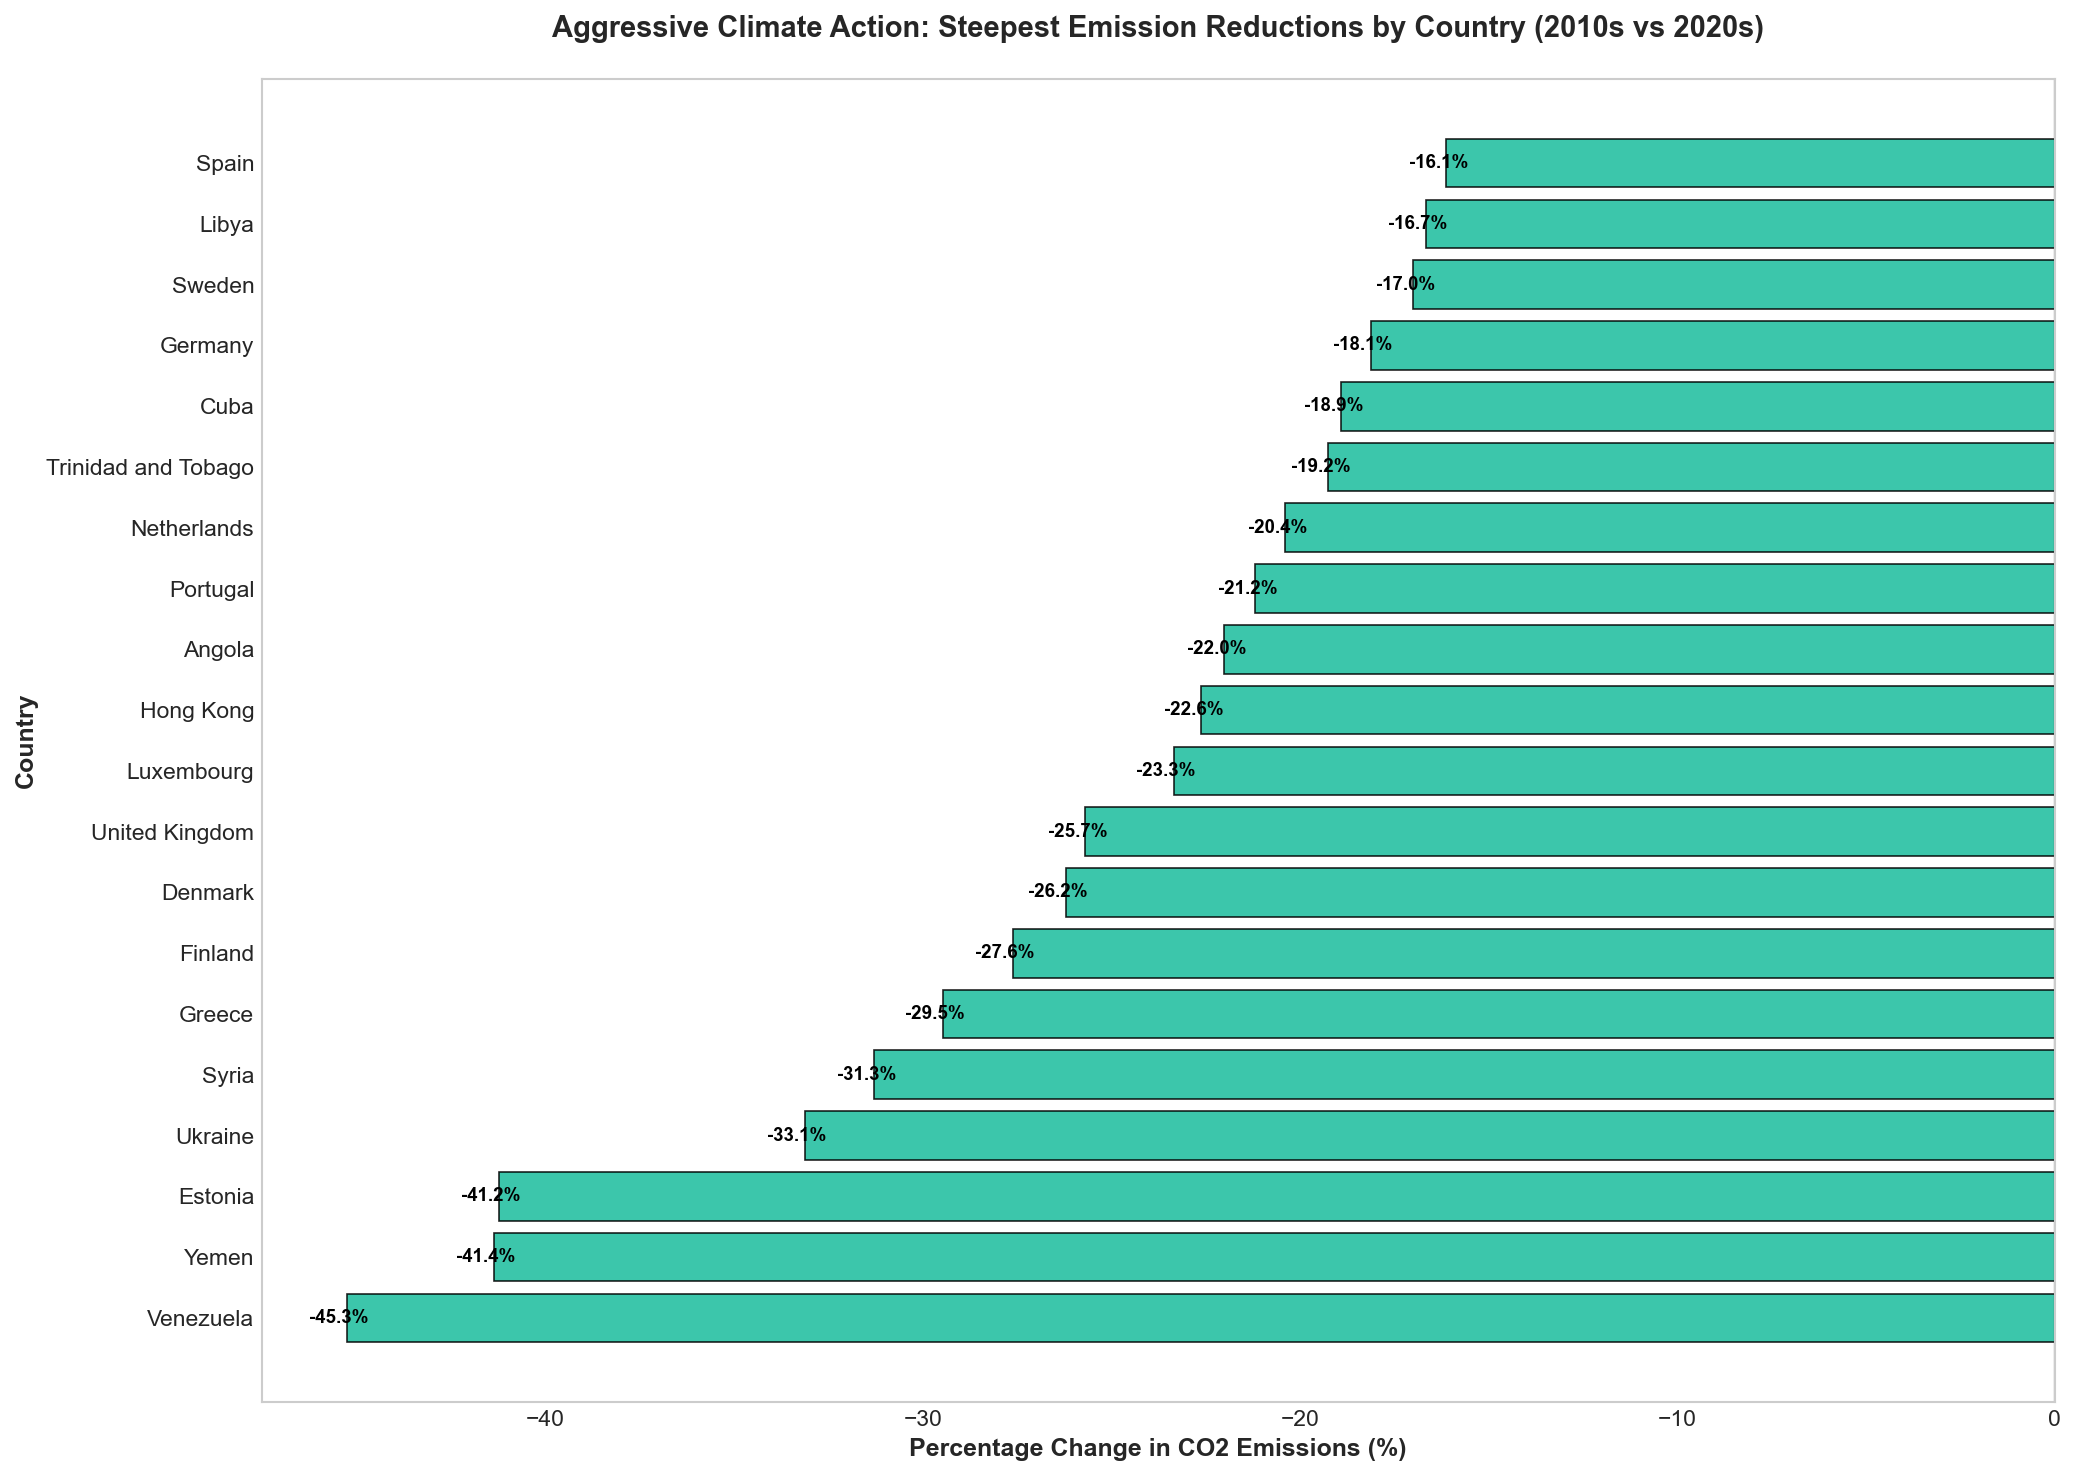

In [17]:
decade_2010s = df[(df['Year'] >= 2010) & (df['Year'] <= 2019)].groupby('Country')['CO2 Emissions'].mean()
decade_2020s = df[(df['Year'] >= 2020) & (df['Year'] <= latest_year)].groupby('Country')['CO2 Emissions'].mean()

# Also compare 2000s vs 2010s for longer-term trends
decade_2000s = df[(df['Year'] >= 2000) & (df['Year'] <= 2009)].groupby('Country')['CO2 Emissions'].mean()

# Calculate percentage changes
decade_change_2010_2020 = pd.DataFrame({
    'Country': decade_2010s.index,
    'Emissions_2010s': decade_2010s.values,
    'Emissions_2020s': decade_2020s.reindex(decade_2010s.index).values
})

decade_change_2010_2020 = decade_change_2010_2020.dropna()
decade_change_2010_2020['Pct_Change'] = ((decade_change_2010_2020['Emissions_2020s'] - decade_change_2010_2020['Emissions_2010s']) / 
                                          decade_change_2010_2020['Emissions_2010s']) * 100

# Filter to significant emitters
decade_change_2010_2020 = decade_change_2010_2020[decade_change_2010_2020['Emissions_2010s'] > 10]

# Sort by reduction (most negative = steepest reduction)
decade_change_2010_2020 = decade_change_2010_2020.sort_values('Pct_Change')

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 10))

# Show top 20 reductions
top_reductions = decade_change_2010_2020.head(20)

# Teal for reductions, Vermilion for increases - colorblind safe
colors = [UN_COLORS['positive'] if x < 0 else UN_COLORS['negative'] for x in top_reductions['Pct_Change']]
bars = ax.barh(top_reductions['Country'], top_reductions['Pct_Change'], color=colors, alpha=0.85,
               edgecolor=UN_COLORS['slate_grey'], linewidth=0.8)

ax.axvline(x=0, color=UN_COLORS['slate_grey'], linestyle='-', linewidth=1.5)
ax.set_xlabel('Percentage Change in CO2 Emissions (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Country', fontsize=12, fontweight='bold')
ax.set_title('Aggressive Climate Action: Steepest Emission Reductions by Country (2010s vs 2020s)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(False)

# Add value labels
for i, (idx, row) in enumerate(top_reductions.iterrows()):
    value = row['Pct_Change']
    ax.text(value + (1 if value > 0 else -1), i, f'{value:.1f}%', 
            va='center', fontsize=9, fontweight='bold', color=UN_COLORS['slate_grey'])

plt.tight_layout()
plt.show()

## Which countries transitioned away from coal most successfully?

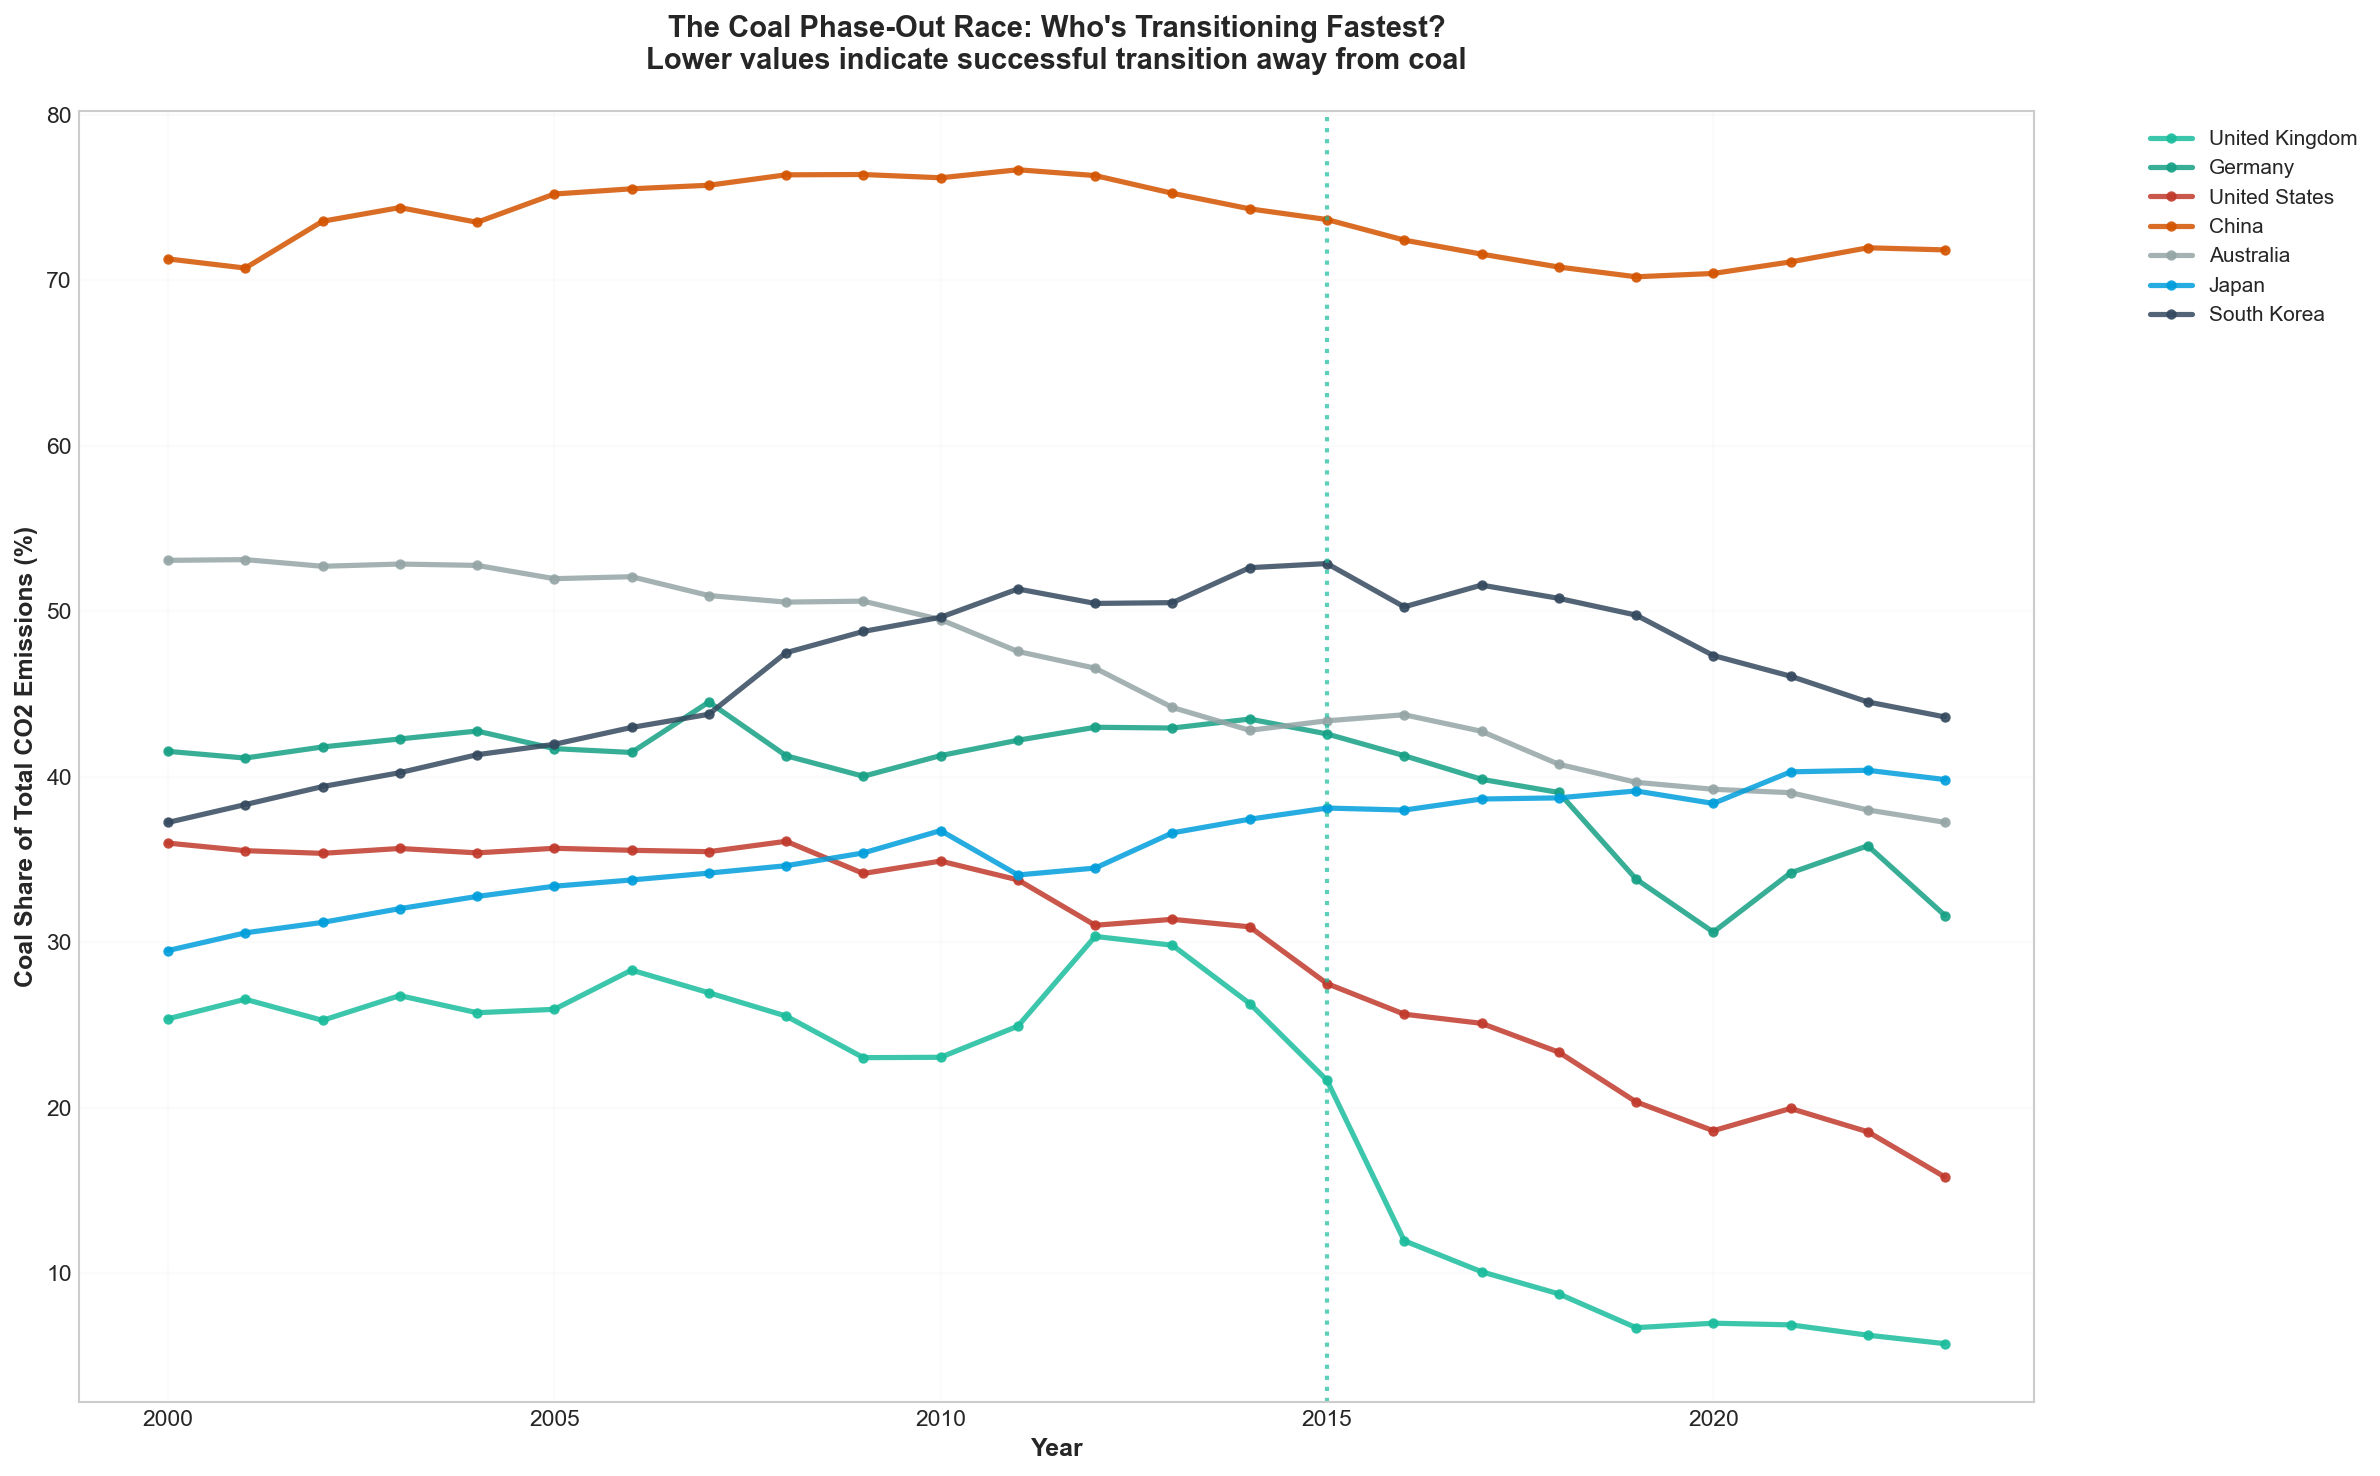

In [18]:
# Select countries known for coal transitions and major coal emitters
coal_countries = ['United Kingdom', 'Germany', 'United States', 'China'
                  , 'Australia', 'Japan', 'South Korea']

# Calculate coal share over time
coal_transition_data = []
for country in coal_countries:
    country_data = df[df['Country'] == country].copy()
    country_data = country_data[country_data['Year'] >= 2000].sort_values('Year')
    country_data['Coal_Share'] = (country_data['Coal CO2 Emissions'] / 
                                  country_data['CO2 Emissions'].replace(0, np.nan)) * 100
    coal_transition_data.append(country_data[['Country', 'Year', 'Coal_Share', 'Coal CO2 Emissions', 'CO2 Emissions']])

coal_transition = pd.concat(coal_transition_data, ignore_index=True)
coal_transition = coal_transition.dropna(subset=['Coal_Share'])

# Create line chart
fig, ax = plt.subplots(figsize=(16, 10))

# Define colors: Leaders (UK, Germany) in Teal shades, Heavy emitters (USA, China, India) in Rust/Orange
coal_country_colors = {
    'United Kingdom': UN_COLORS['lower_middle'],  # Teal - leader
    'Germany': '#16A085',  # Dark Teal - leader
    'United States': UN_COLORS['high_income'],  # Rust
    'China': UN_COLORS['negative'],  # Dark Orange
    'India': '#E67E22',  # Orange
    'Poland': UN_COLORS['upper_middle'],  # Mustard
    'Australia': '#95A5A6',  # Light Grey
    'South Africa': '#7F8C8D',  # Grey
    'Japan': UN_COLORS['un_blue'],  # UN Blue
    'South Korea': '#34495E'  # Dark Blue-Grey
}

for country in coal_countries:
    country_data = coal_transition[coal_transition['Country'] == country].sort_values('Year')
    if len(country_data) > 0:
        ax.plot(country_data['Year'], country_data['Coal_Share'], 
               marker='o', linewidth=2.5, label=country, alpha=0.85, markersize=4,
               color=coal_country_colors.get(country, UN_COLORS['slate_grey']))

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Coal Share of Total CO2 Emissions (%)', fontsize=12, fontweight='bold')
ax.set_title('The Coal Phase-Out Race: Who\'s Transitioning Fastest?\nLower values indicate successful transition away from coal', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, frameon=False)
ax.grid(True, alpha=0.2, color='#ECEFF1')
ax.axvline(x=2015, color=UN_COLORS['positive'], linestyle=':', linewidth=2, alpha=0.7, label='Paris Agreement')

plt.tight_layout()
plt.show()

## Which countries should reach net-zero by 2040, 2050, vs 2060?

Analyzing data for year: 2023


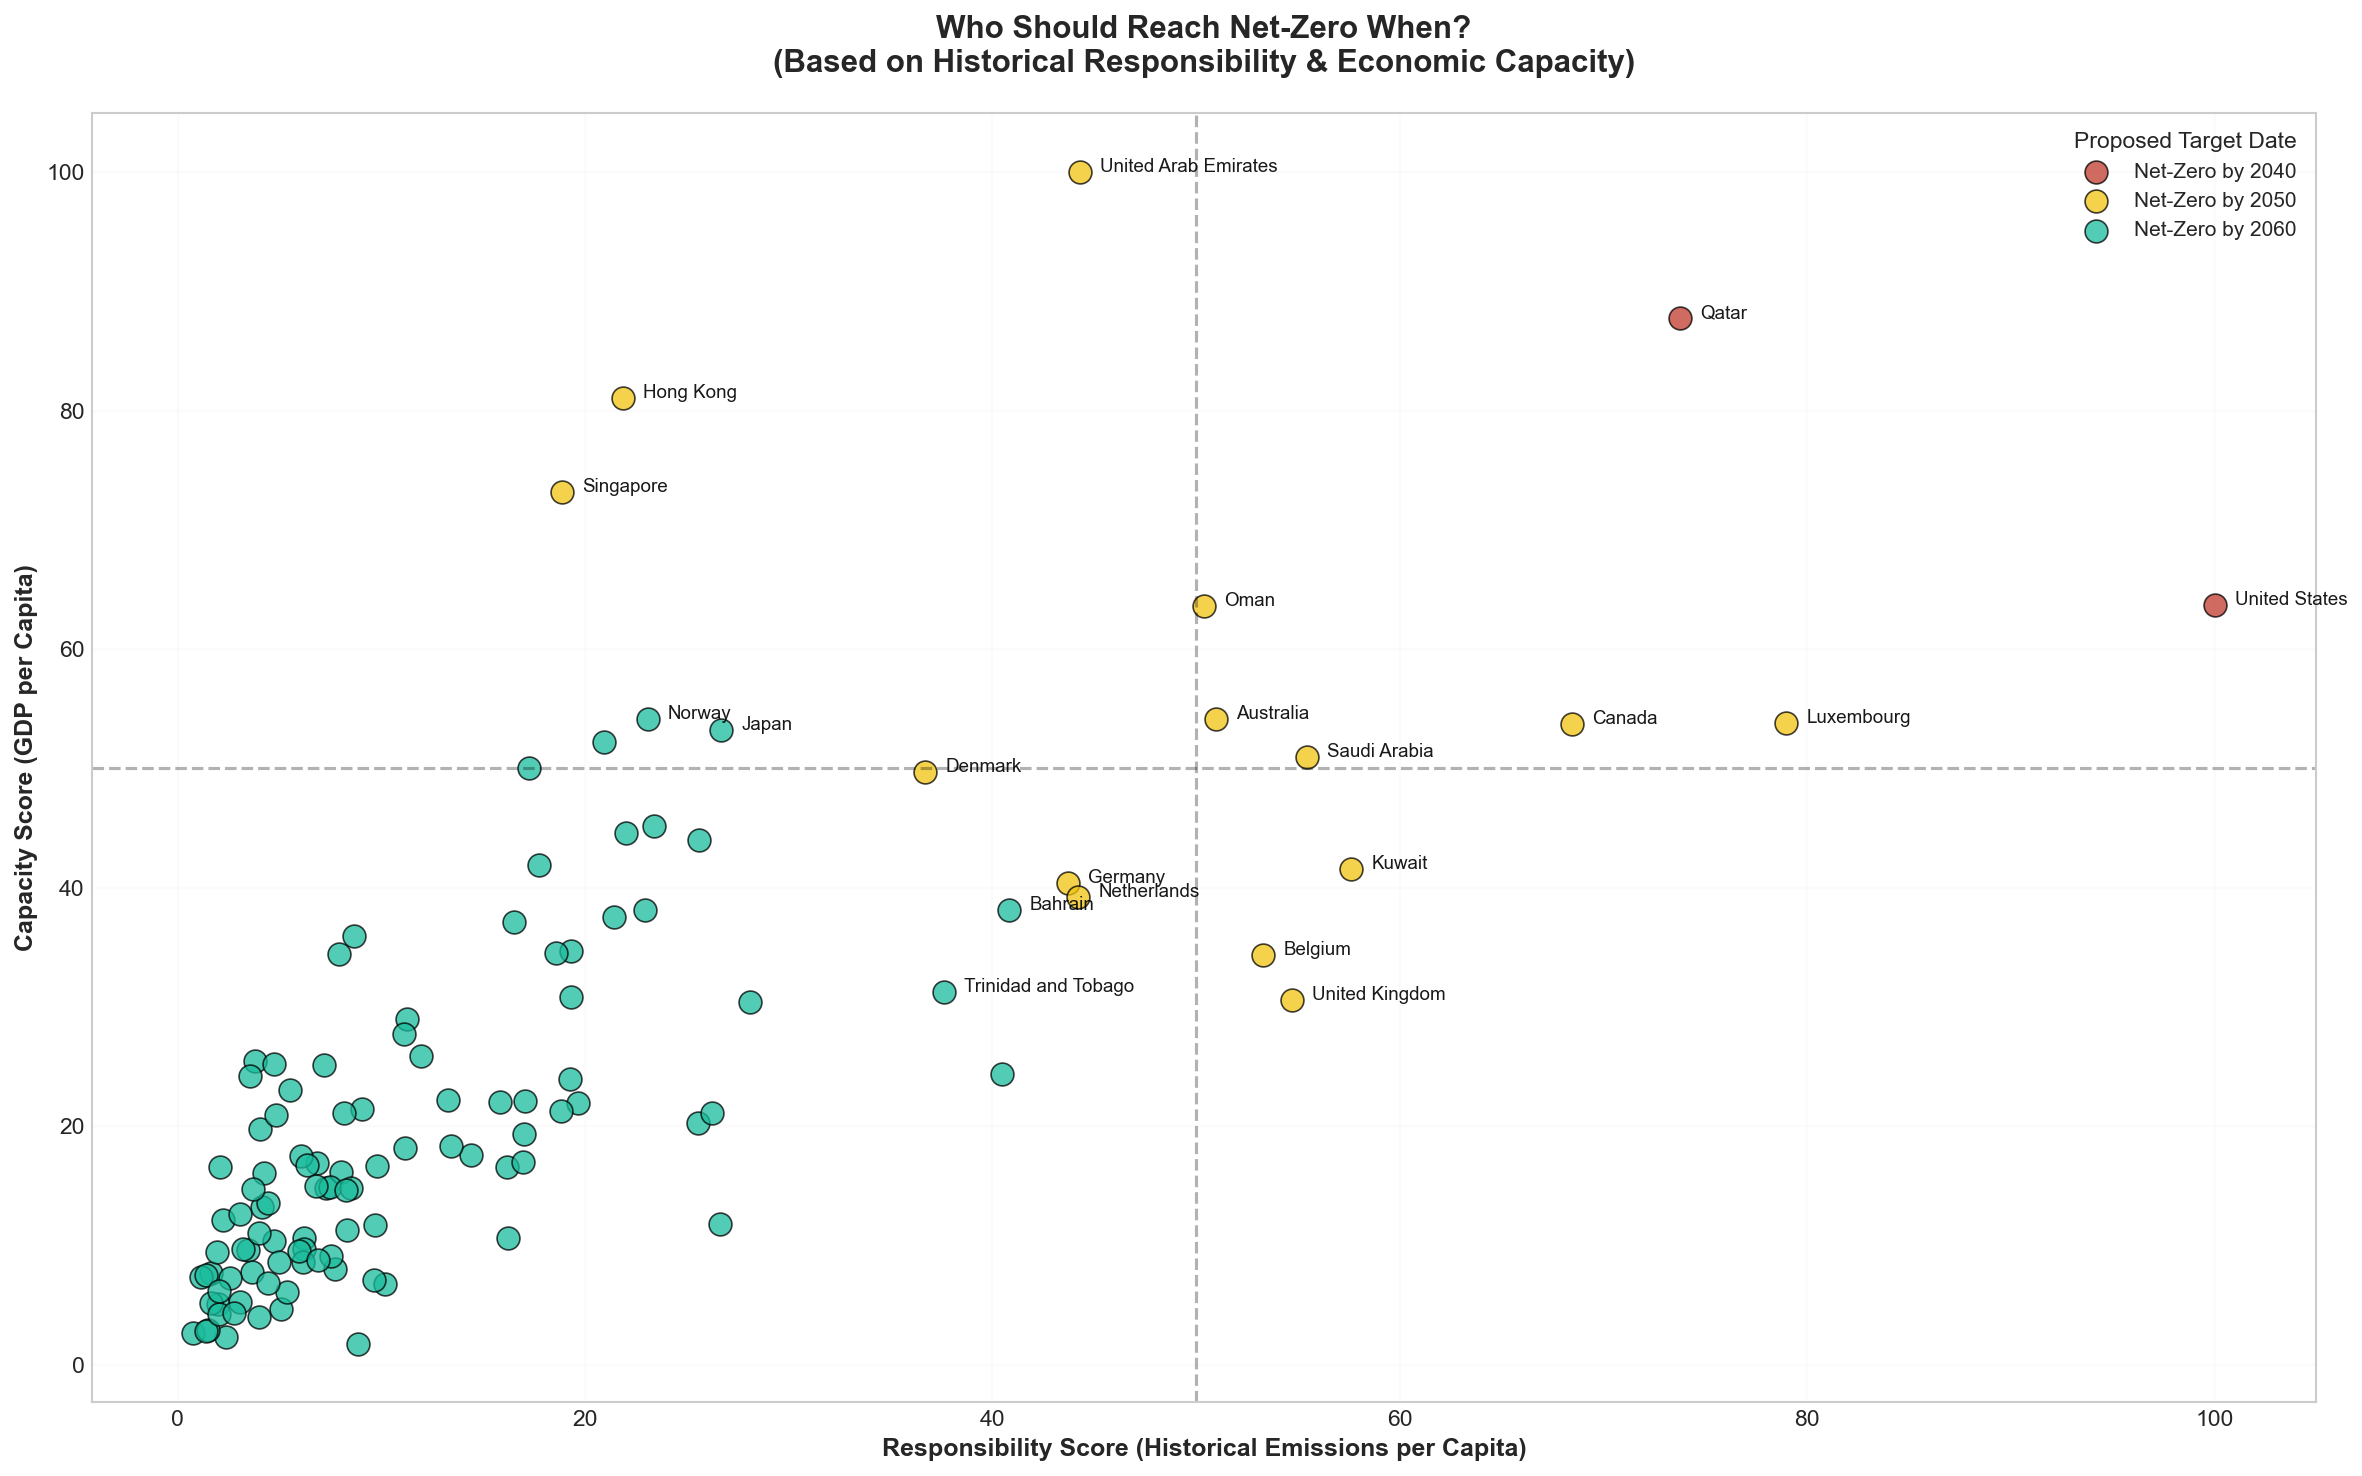

In [19]:
if 'latest_year' not in locals():
    latest_year = df[df['CO2 Emissions'].notna()]['Year'].max()
print(f"Analyzing data for year: {latest_year}")

# Create a copy of the data for the latest year
latest_data = df[df['Year'] == latest_year].copy()

# Filter for rows that actually have the necessary metrics
latest_data = latest_data[
    (latest_data['Population'].notna()) & 
    (latest_data['Gross Domestic Product'].notna()) & 
    (latest_data['CO2 Emissions'].notna())
]

# --- 2. Calculate Metrics (The Fix) ---
# FIX: Convert CO2 from Megatonnes (Mt) to Tonnes (* 1e6) for per capita calculations
# This ensures the numbers are roughly 1-20 tonnes, not 0.000001
latest_data['GDP_per_capita'] = latest_data['Gross Domestic Product'] / latest_data['Population']
latest_data['Emissions_per_capita'] = (latest_data['CO2 Emissions'] * 1_000_000) / latest_data['Population']

# Calculate cumulative emissions per capita (Historical Responsibility)
# We also convert cumulative emissions to Tonnes here for consistency
cumulative_emissions = df.groupby('Country')['CO2 Emissions'].sum() * 1_000_000
cumulative_population = df.groupby('Country')['Population'].mean() 
cumulative_per_capita = cumulative_emissions / cumulative_population.replace(0, np.nan)

# Merge data
netzero_analysis = latest_data[['Country', 'Income Group', 'GDP_per_capita', 'Emissions_per_capita']].copy()
netzero_analysis['Cumulative_per_capita'] = netzero_analysis['Country'].map(cumulative_per_capita)

# Drop countries missing history data
netzero_analysis = netzero_analysis.dropna()

# --- 3. Scoring & Normalization ---
# Normalize scores to 0-100 scale relative to the max value in the dataset
netzero_analysis['Capacity_Score'] = (netzero_analysis['GDP_per_capita'] / netzero_analysis['GDP_per_capita'].max()) * 100
netzero_analysis['Responsibility_Score'] = (netzero_analysis['Cumulative_per_capita'] / netzero_analysis['Cumulative_per_capita'].max()) * 100

# Calculate Combined Score (Weighted: 60% Responsibility, 40% Capacity)
netzero_analysis['Combined_Score'] = (netzero_analysis['Responsibility_Score'] * 0.6 + 
                                      netzero_analysis['Capacity_Score'] * 0.4)

# Assign Targets
def assign_target(score):
    if score >= 70: return '2040'
    elif score >= 40: return '2050'
    else: return '2060'

netzero_analysis['NetZero_Target'] = netzero_analysis['Combined_Score'].apply(assign_target)

# --- 4. Filtering for Visualization ---
# FIX: Now that units are in Tonnes, > 1.0 is a reasonable filter (1 ton per person)
# This removes very small island nations or data errors, but keeps major economies
netzero_viz = netzero_analysis[netzero_analysis['Emissions_per_capita'] > 1.0].copy()

# Safety check
if len(netzero_viz) == 0:
    print("Warning: Filter is too strict. Resetting to show top 50 emitters.")
    netzero_viz = netzero_analysis.nlargest(50, 'Combined_Score')

# --- 5. Visualization ---
fig, ax = plt.subplots(figsize=(16, 10))

# UN Colors: 2040 (urgent) = Rust, 2050 (standard) = Mustard, 2060 (lenient) = Teal
colors_map = {
    '2040': UN_COLORS['high_income'],     # Rust - most urgent
    '2050': UN_COLORS['upper_middle'],    # Mustard - standard
    '2060': UN_COLORS['lower_middle']     # Teal - lenient
}

# Plot scatter points
for target_year in sorted(netzero_viz['NetZero_Target'].unique()):
    target_data = netzero_viz[netzero_viz['NetZero_Target'] == target_year]
    ax.scatter(target_data['Responsibility_Score'], target_data['Capacity_Score'],
               c=colors_map.get(target_year, UN_COLORS['slate_grey']), 
               label=f'Net-Zero by {target_year}', 
               alpha=0.75, s=120, edgecolors=UN_COLORS['slate_grey'], linewidth=0.8)

# Annotate top countries
# We annotate the top 15 by combined score, plus a few specific major economies if interested
top_countries = netzero_viz.nlargest(20, 'Combined_Score')
for _, row in top_countries.iterrows():
    ax.text(row['Responsibility_Score']+1, row['Capacity_Score'], row['Country'], 
            fontsize=9, alpha=0.9, fontweight='medium', color=UN_COLORS['slate_grey'])

# Formatting
ax.set_xlabel('Responsibility Score (Historical Emissions per Capita)', fontsize=12, fontweight='bold')
ax.set_ylabel('Capacity Score (GDP per Capita)', fontsize=12, fontweight='bold')
ax.set_title('Who Should Reach Net-Zero When?\n(Based on Historical Responsibility & Economic Capacity)', 
             fontsize=15, fontweight='bold', pad=20)

# Add quadrant lines for context
ax.axhline(y=50, color=UN_COLORS['slate_grey'], linestyle='--', alpha=0.3)
ax.axvline(x=50, color=UN_COLORS['slate_grey'], linestyle='--', alpha=0.3)

ax.legend(title="Proposed Target Date", fontsize=10, title_fontsize=11, frameon=False)
ax.grid(True, alpha=0.2, color='#ECEFF1')

plt.tight_layout()
plt.show()

## At current regional growth rates, when will Asia's emissions surpass historical cumulative emissions of Europe+USA?

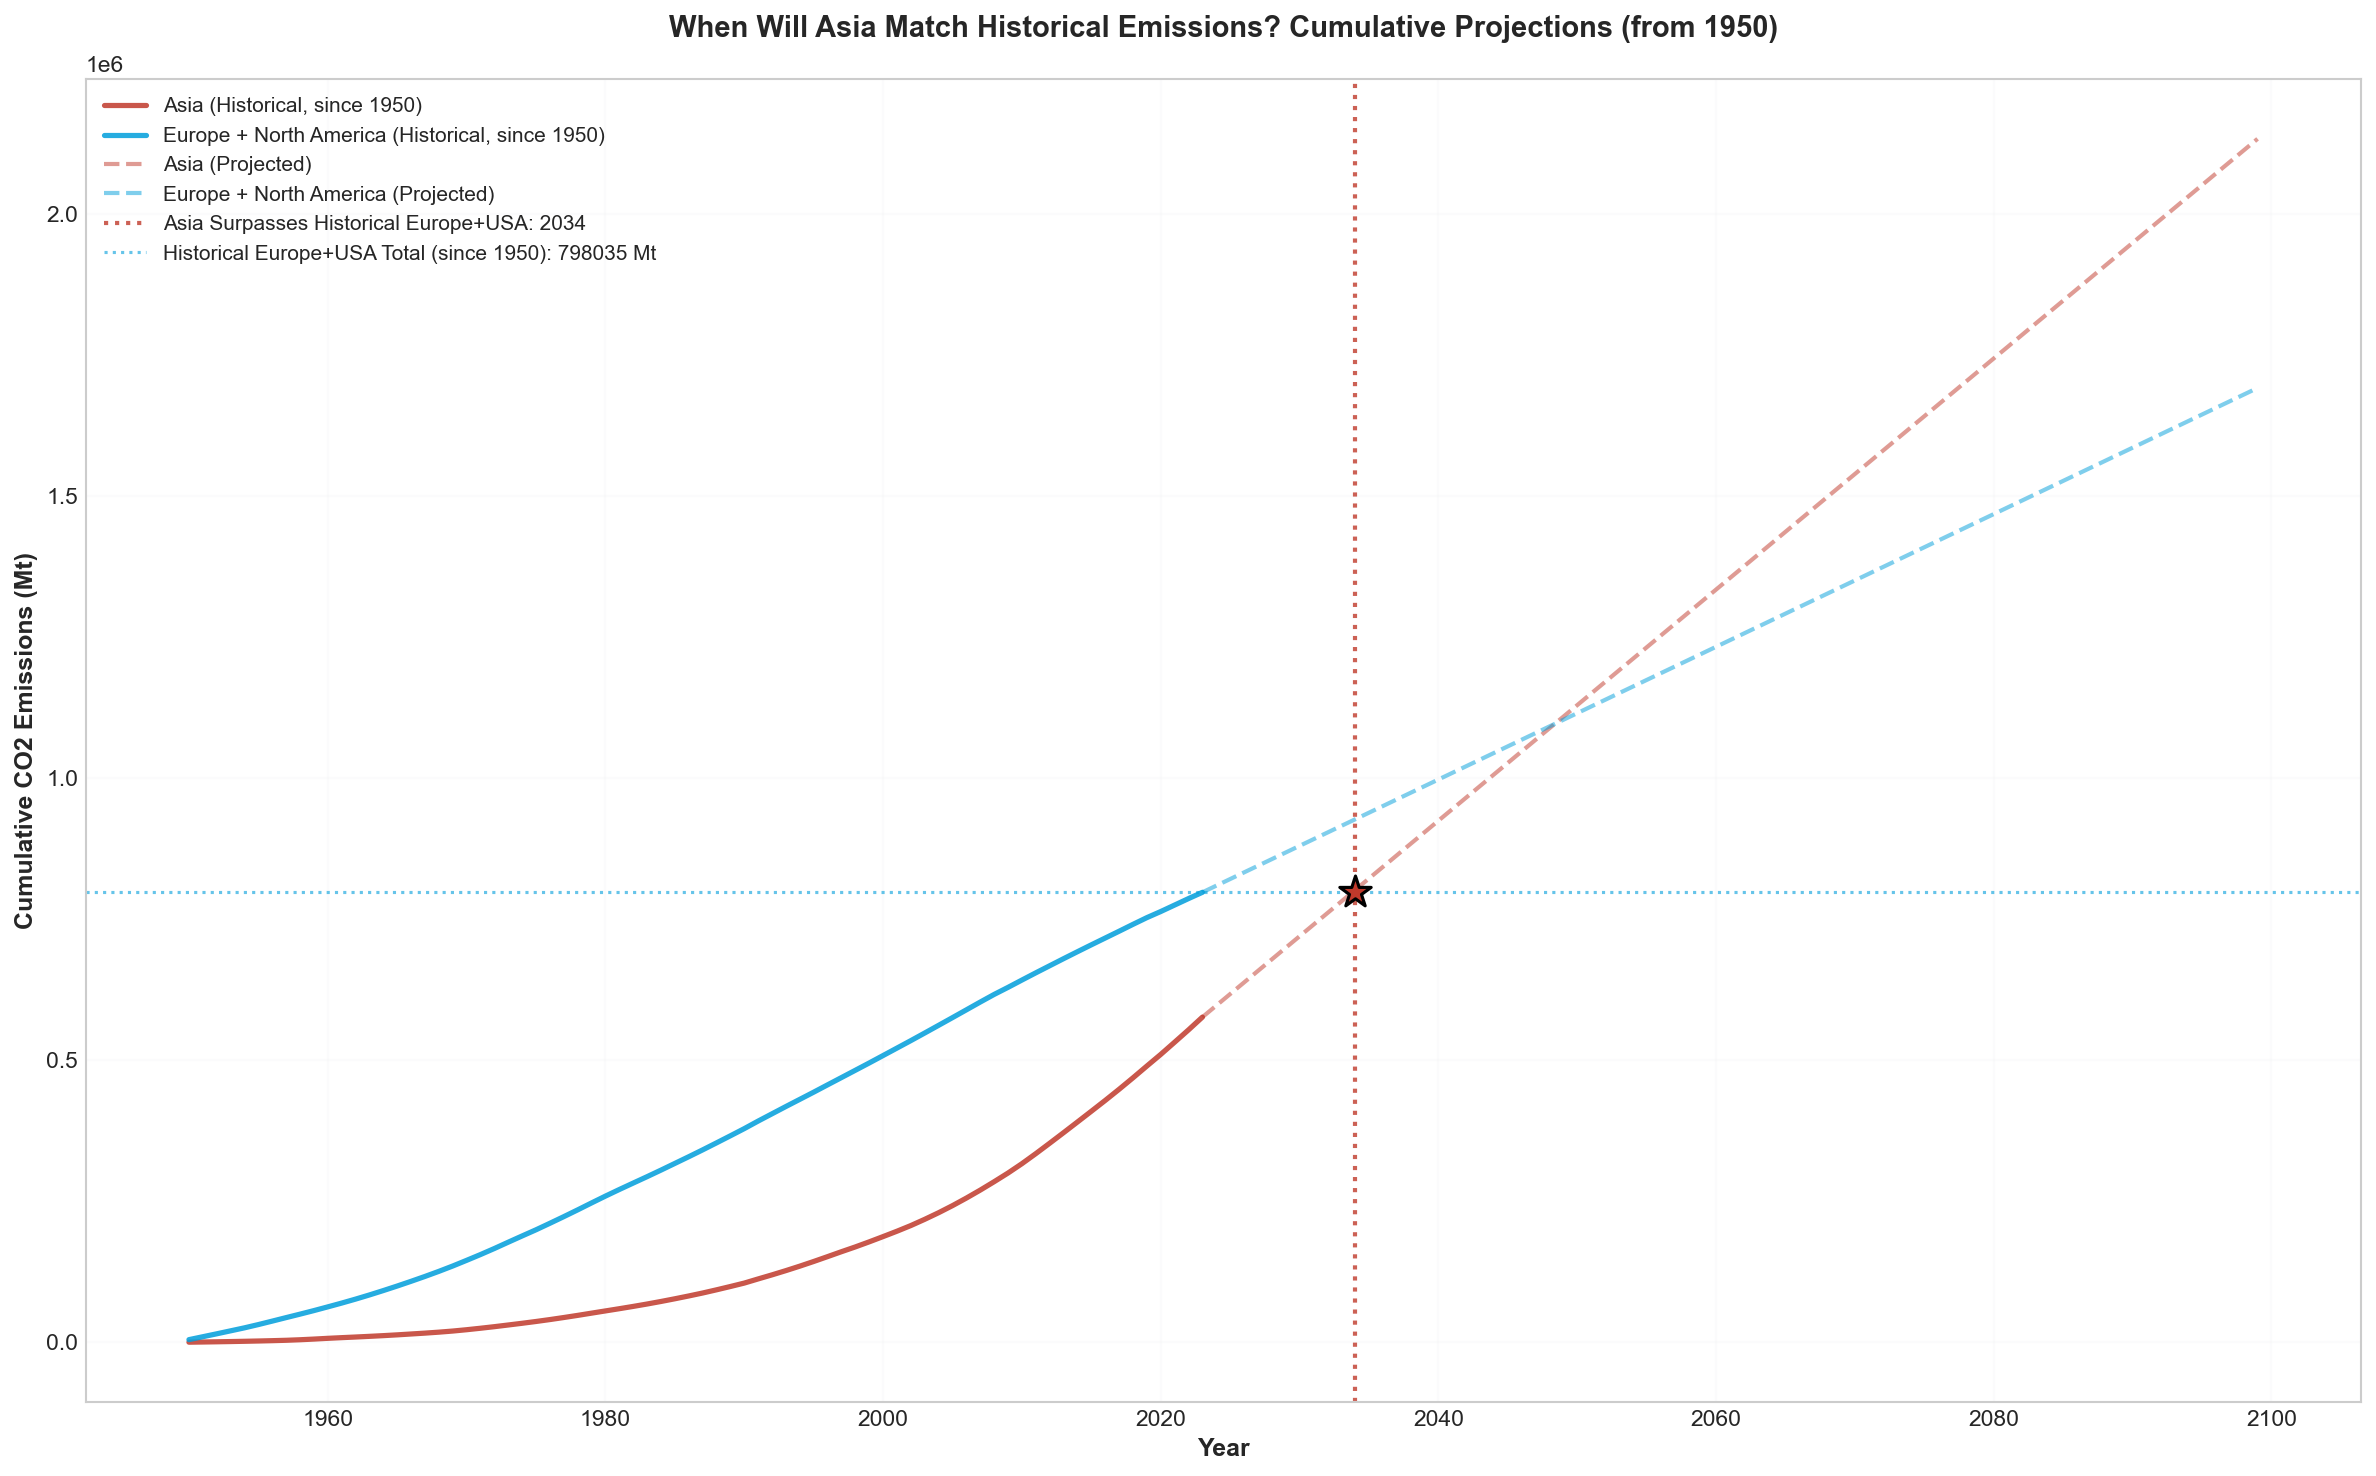

In [20]:
# Filter data for years >= 1950
df1950 = df[df['Year'] >= 1950].copy()

# Calculate cumulative emissions by region starting from 1950
asia_data = df1950[df1950['Continent'] == 'Asia'].groupby('Year')['CO2 Emissions'].sum().sort_index()
europe_data = df1950[df1950['Continent'] == 'Europe'].groupby('Year')['CO2 Emissions'].sum().sort_index()
north_america_data = df1950[df1950['Continent'] == 'North America'].groupby('Year')['CO2 Emissions'].sum().sort_index()

# Calculate cumulative totals
asia_cumulative = asia_data.cumsum()
europe_cumulative = europe_data.cumsum()
north_america_cumulative = north_america_data.cumsum()
europe_usa_cumulative = europe_cumulative + north_america_cumulative

# Get historical cumulative totals (up to latest year, from 1950 onwards)
asia_total_historical = asia_cumulative.iloc[-1] if len(asia_cumulative) > 0 else 0
europe_usa_total_historical = europe_usa_cumulative.iloc[-1] if len(europe_usa_cumulative) > 0 else 0

# Calculate recent growth rates (last 10 years, from 1950 onwards)
recent_years = sorted(df1950['Year'].unique())[-10:]
asia_recent = df1950[(df1950['Continent'] == 'Asia') & (df1950['Year'].isin(recent_years))].groupby('Year')['CO2 Emissions'].sum()
europe_recent = df1950[(df1950['Continent'] == 'Europe') & (df1950['Year'].isin(recent_years))].groupby('Year')['CO2 Emissions'].sum()
north_america_recent = df1950[(df1950['Continent'] == 'North America') & (df1950['Year'].isin(recent_years))].groupby('Year')['CO2 Emissions'].sum()

# Calculate average annual emissions for projection
asia_avg_annual = asia_recent.mean() if len(asia_recent) > 0 else 0
europe_avg_annual = europe_recent.mean() if len(europe_recent) > 0 else 0
north_america_avg_annual = north_america_recent.mean() if len(north_america_recent) > 0 else 0

# Project forward
latest_year = df1950['Year'].max()
projection_years = list(range(latest_year + 1, 2100))

# Project cumulative emissions
asia_projected_cumulative = []
europe_usa_projected_cumulative = []

current_asia_cum = asia_total_historical
current_europe_usa_cum = europe_usa_total_historical

crossover_year = None
for year in projection_years:
    current_asia_cum += asia_avg_annual
    current_europe_usa_cum += (europe_avg_annual + north_america_avg_annual)
    asia_projected_cumulative.append(current_asia_cum)
    europe_usa_projected_cumulative.append(current_europe_usa_cum)
    
    # Find crossover point
    if (crossover_year is None) and (current_asia_cum >= europe_usa_total_historical):
        crossover_year = year

# Create cumulative line chart with projection
fig, ax = plt.subplots(figsize=(16, 10))

# Historical data (from 1950) - Use UN colors: Asia = Rust, Europe+USA = UN Blue
historical_years = sorted(df1950['Year'].unique())
ax.plot(historical_years, asia_cumulative.reindex(historical_years, fill_value=0), 
       linewidth=2.5, label='Asia (Historical, since 1950)', color=UN_COLORS['high_income'], alpha=0.85)
ax.plot(historical_years, europe_usa_cumulative.reindex(historical_years, fill_value=0), 
       linewidth=2.5, label='Europe + North America (Historical, since 1950)', color=UN_COLORS['un_blue'], alpha=0.85)

# Projected data
all_projection_years = [latest_year] + projection_years
asia_all = [asia_total_historical] + asia_projected_cumulative
europe_usa_all = [europe_usa_total_historical] + europe_usa_projected_cumulative

ax.plot(all_projection_years, asia_all, '--', linewidth=2, 
       label='Asia (Projected)', color=UN_COLORS['high_income'], alpha=0.5)
ax.plot(all_projection_years, europe_usa_all, '--', linewidth=2, 
       label='Europe + North America (Projected)', color=UN_COLORS['un_blue'], alpha=0.5)

# Mark crossover point
if crossover_year is not None:
    ax.axvline(x=crossover_year, color=UN_COLORS['high_income'], linestyle=':', linewidth=2, 
              label=f'Asia Surpasses Historical Europe+USA: {crossover_year}', alpha=0.8)
    ax.scatter([crossover_year], [europe_usa_total_historical], 
              color=UN_COLORS['high_income'], s=250, zorder=5, marker='*', 
              edgecolors=UN_COLORS['slate_grey'], linewidths=1.5)

# Mark historical total
ax.axhline(y=europe_usa_total_historical, color=UN_COLORS['un_blue'], linestyle=':', linewidth=1.5, 
          alpha=0.6, label=f'Historical Europe+USA Total (since 1950): {europe_usa_total_historical:.0f} Mt')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative CO2 Emissions (Mt)', fontsize=12, fontweight='bold')
ax.set_title('When Will Asia Match Historical Emissions? Cumulative Projections (from 1950)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10, frameon=False)
ax.grid(True, alpha=0.2, color='#ECEFF1')

plt.tight_layout()
plt.show()

### How did 2020 affect emissions and what was the rebound pattern?

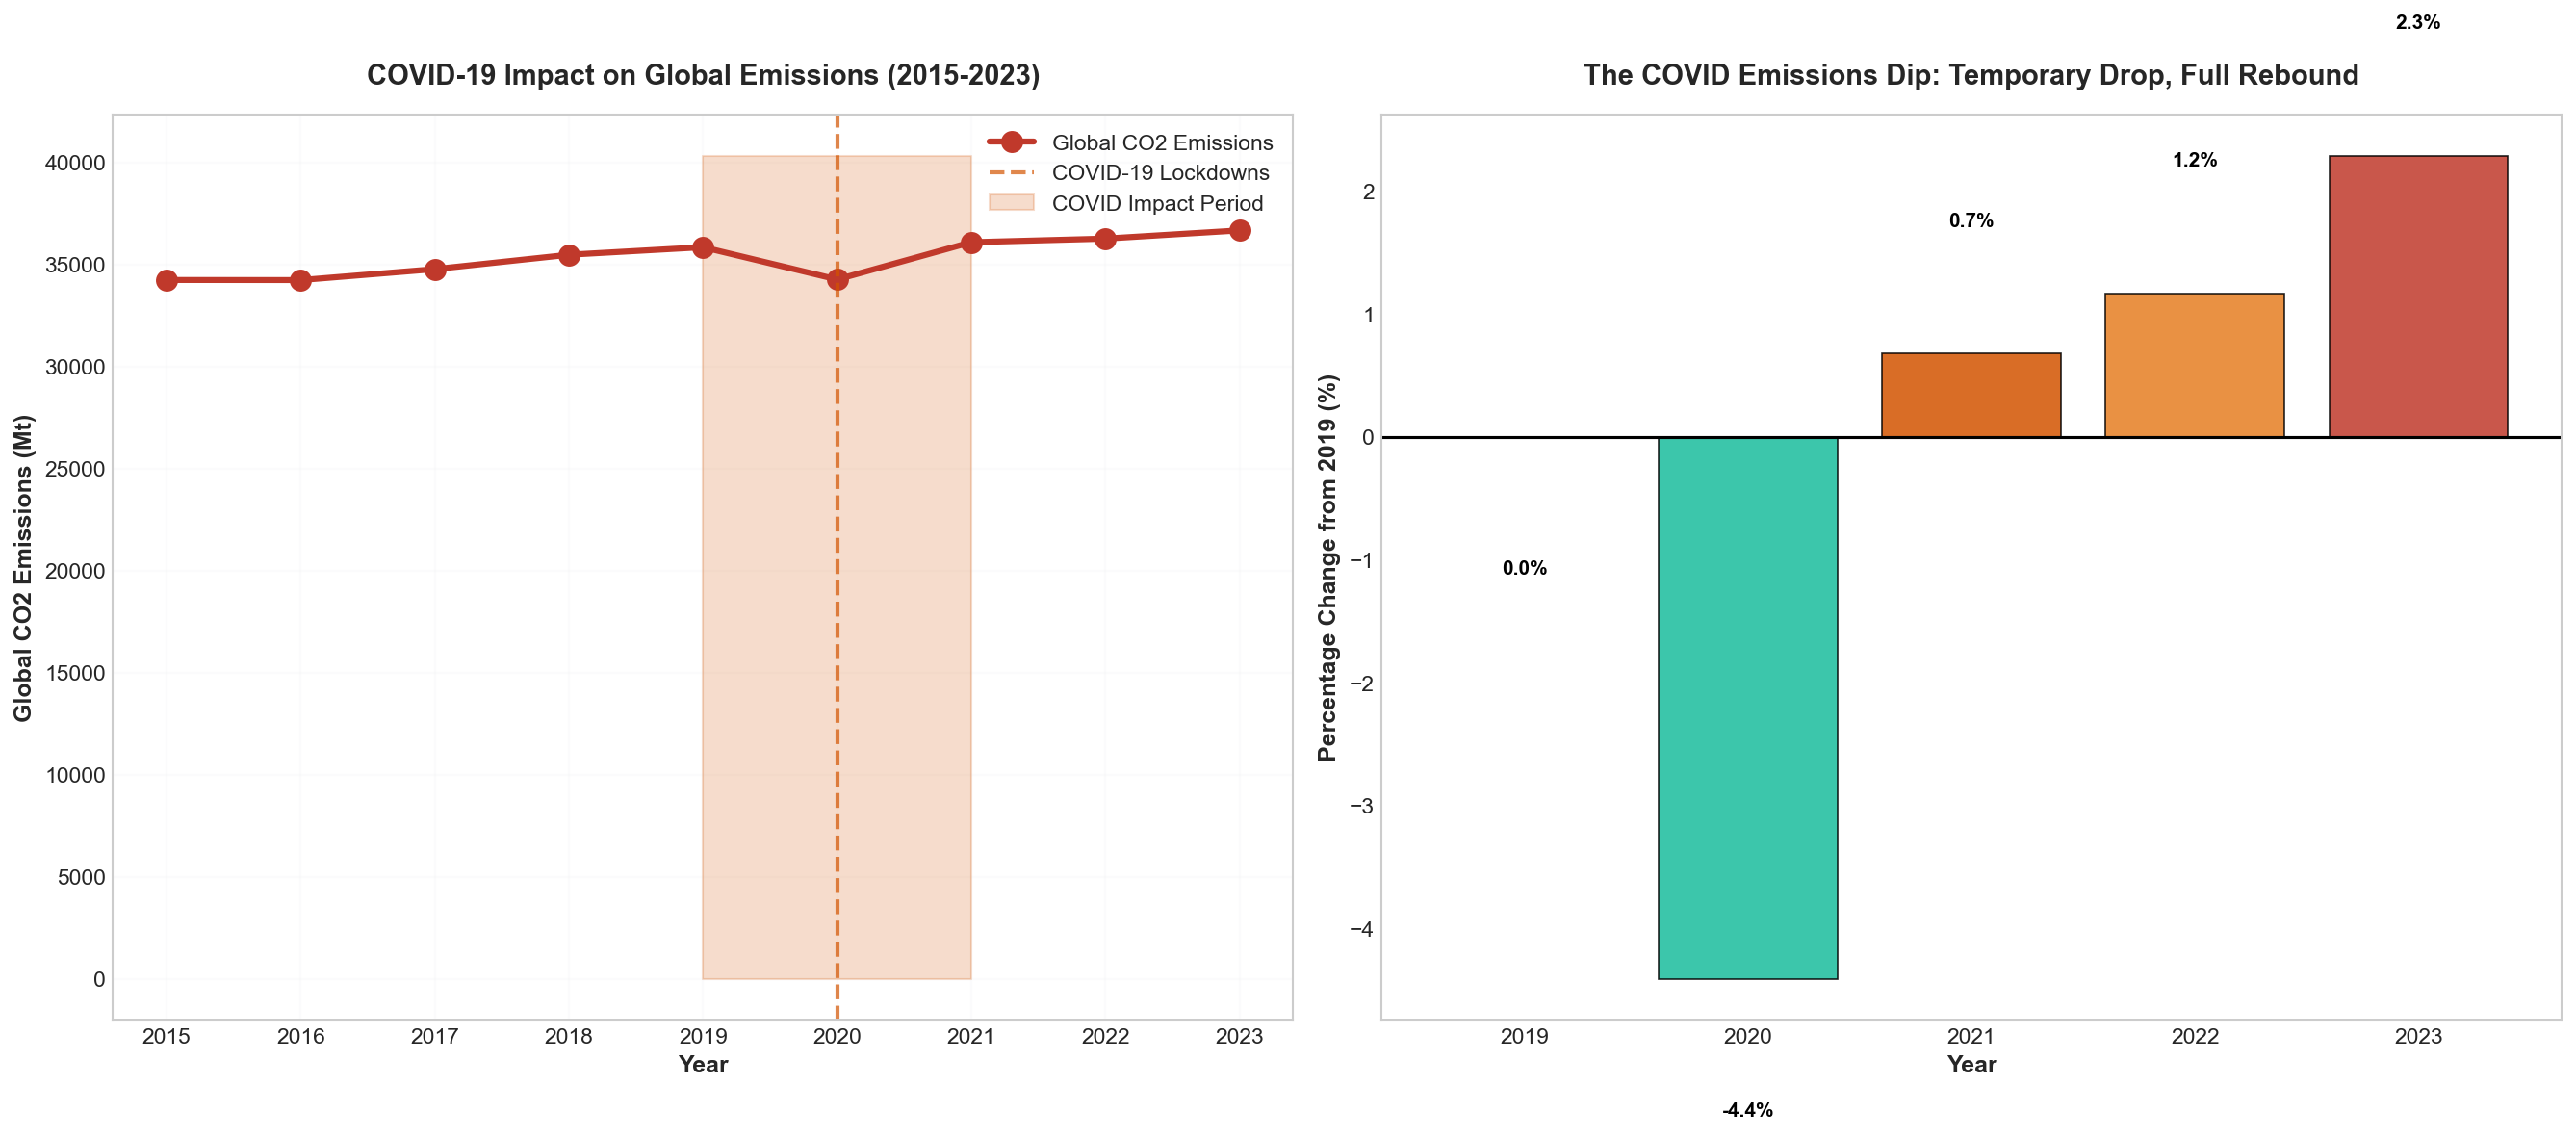

In [21]:
# Analyze COVID-19 impact on global emissions
global_emissions = df.groupby('Year')['CO2 Emissions'].sum()
covid_years = [2019, 2020, 2021, 2022, 2023]

# Calculate changes
covid_impact = pd.DataFrame({
    'Year': covid_years,
    'Global_Emissions': [global_emissions.get(year, 0) for year in covid_years]
})

covid_impact['Change_from_2019'] = covid_impact['Global_Emissions'] - covid_impact['Global_Emissions'].iloc[0]
covid_impact['Pct_Change_from_2019'] = (covid_impact['Change_from_2019'] / covid_impact['Global_Emissions'].iloc[0]) * 100

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Chart 1: Global emissions trend - Use Rust for emissions line
years_range = list(range(2015, 2024))
ax1.plot(years_range, [global_emissions.get(year, 0) for year in years_range], 
        marker='o', linewidth=3, markersize=10, color=UN_COLORS['high_income'], label='Global CO2 Emissions')
ax1.axvline(x=2020, color=UN_COLORS['negative'], linestyle='--', linewidth=2, alpha=0.7, label='COVID-19 Lockdowns')
ax1.fill_between([2019, 2021], [0, 0], [global_emissions.max() * 1.1], alpha=0.2, 
                 color=UN_COLORS['negative'], label='COVID Impact Period')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Global CO2 Emissions (Mt)', fontsize=12, fontweight='bold')
ax1.set_title('COVID-19 Impact on Global Emissions (2015-2023)', fontsize=14, fontweight='bold', pad=15)
ax1.legend(frameon=False)
ax1.grid(True, alpha=0.2, color='#ECEFF1')

# Chart 2: Percentage change from 2019
# 2019 (baseline) = Slate Grey, 2020 (drop) = Teal, 2021-2023 (rebound) = Vermilion shades
colors_bar = [
    UN_COLORS['slate_grey'],      # 2019 baseline
    UN_COLORS['positive'],         # 2020 drop (Teal)
    UN_COLORS['negative'],         # 2021 rebound (Vermilion)
    '#E67E22',                     # 2022 rebound (Orange)
    UN_COLORS['high_income']       # 2023 rebound (Rust)
]
bars = ax2.bar(covid_impact['Year'], covid_impact['Pct_Change_from_2019'], color=colors_bar, alpha=0.85,
               edgecolor=UN_COLORS['slate_grey'], linewidth=0.8)
ax2.axhline(y=0, color=UN_COLORS['slate_grey'], linestyle='-', linewidth=1.5)
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage Change from 2019 (%)', fontsize=12, fontweight='bold')
ax2.set_title('The COVID Emissions Dip: Temporary Drop, Full Rebound', fontsize=14, fontweight='bold', pad=15)
ax2.grid(False)

for i, (year, pct) in enumerate(zip(covid_impact['Year'], covid_impact['Pct_Change_from_2019'])):
    ax2.text(year, pct + (1 if pct > 0 else -1), f'{pct:.1f}%', 
            ha='center', va='bottom' if pct > 0 else 'top', fontsize=10, fontweight='bold',
            color=UN_COLORS['slate_grey'])

plt.tight_layout()
plt.show()